# <font color="orange"><b>Fine-tune the Llama-3 Base Model for Conversational AI for Job Search App</b></font>

<i>Applications of NL(X) and LLM
<br>95820  - Fall 2024</i>
<br><font color="orange"><b>Author: Karl Cao, Sarthak Bisht, Ahmad Furqan</b></font>

<font color="orange"><b>Code Citation:</b></font>
<i>All Python codes and the step-by-step process for Fine-Tuning method are inspired by the Jupyter Notebook <i>LLM_Finetuning.ipynb</i> from class material.</i>

---

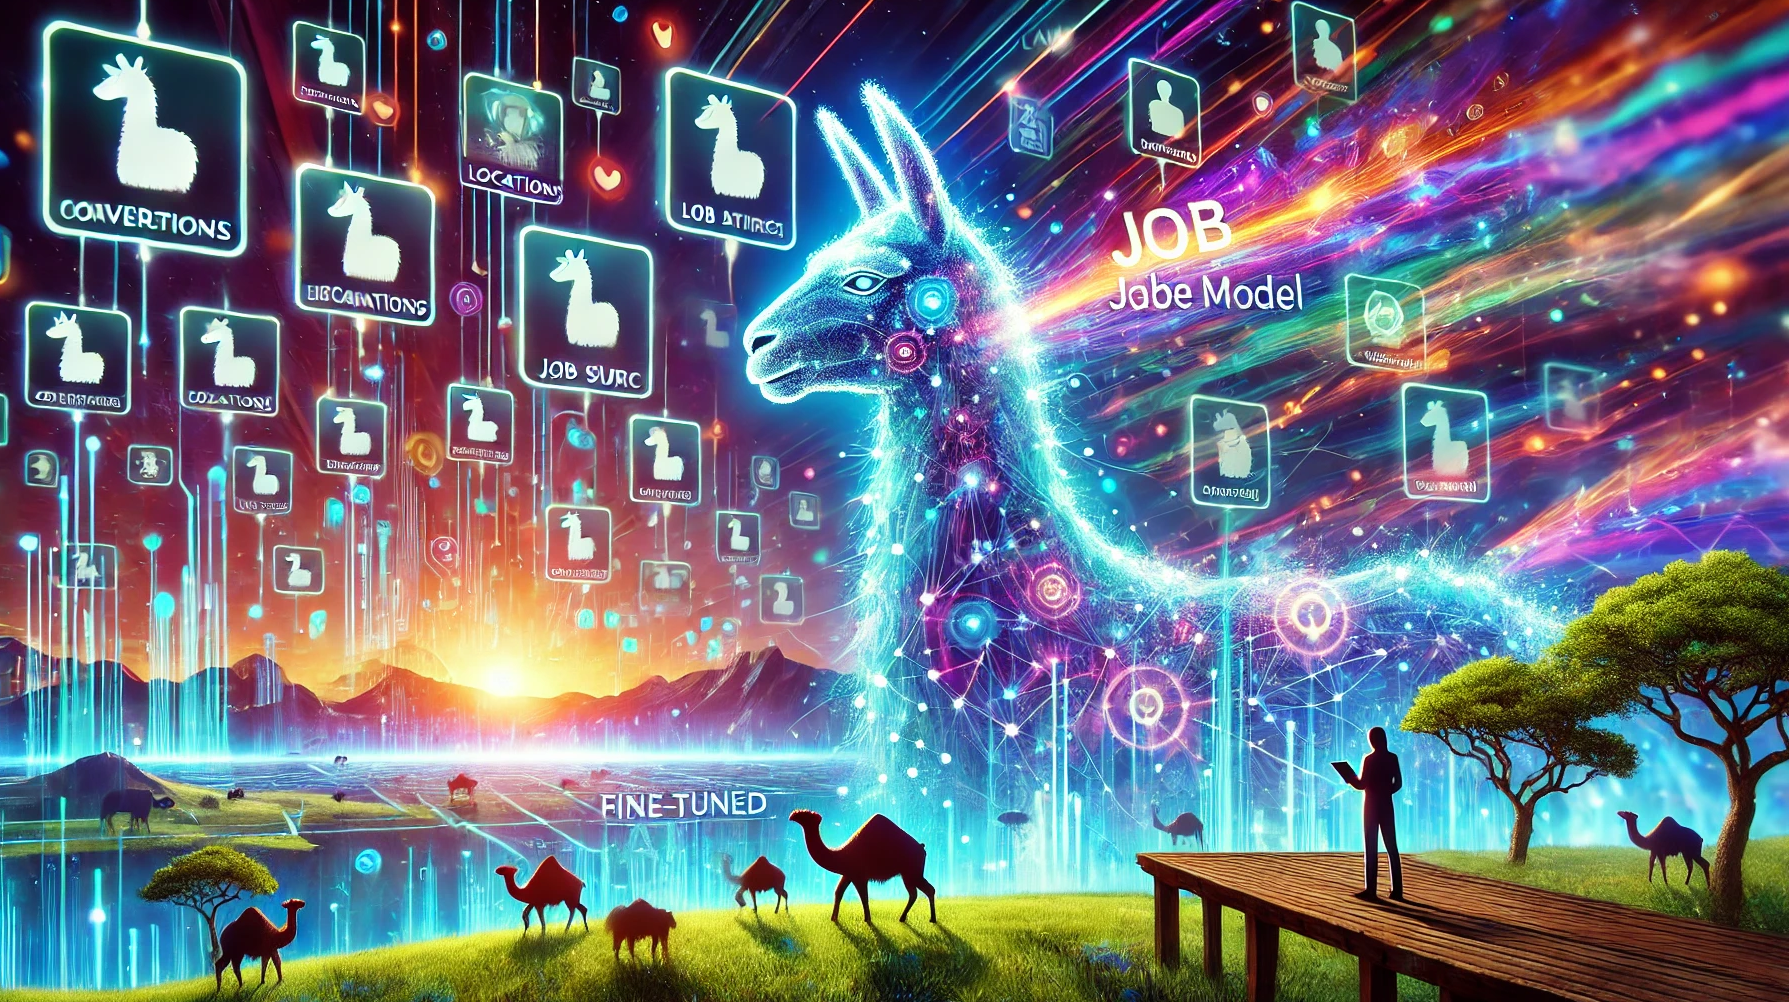

<font size="2pt" color="red">image citation: DALL·E - OpenAI</font>

---

## **Model Selection**

### **Install Dependencies**

In [ ]:
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install transformers datasets deepspeed trl
!pip install evaluate matplotlib seaborn bert-score rouge-score

In [ ]:
import time
from bert_score import score
from rouge_score import rouge_scorer
import evaluate

import torch
from unsloth import FastLanguageModel

import pandas as pd
import numpy as np
from datasets import Dataset

from unsloth.chat_templates import get_chat_template

# Generate response
from transformers import TextStreamer

import matplotlib.pyplot as plt
import os
import re

from math import pi
from sklearn.metrics import precision_score
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer
from transformers import TrainingArguments, TrainerCallback
from unsloth import is_bfloat16_supported
from evaluate import load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Load Libraries and Set Up the Model**

In [ ]:
# Load the base model (Phi-3.5-mini-instruct)
base_model = "unsloth/Phi-3.5-mini-instruct"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=base_model,
    max_seq_length=2048, # Change based on your hardware capabilities
    dtype=None, # Use auto detection
    load_in_4bit=True, # For memory optimization
)


==((====))==  Unsloth 2024.9.post4: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### **Loading Dataset**

In [ ]:
# Load train and test datasets
train_df = pd.read_csv('/content/drive/MyDrive/NLX Data/conversational_train.csv', encoding='utf-8')
test_df = pd.read_csv('/content/drive/MyDrive/NLX Data/conversational_test.csv', encoding='utf-8')

# Prepare datasets as HuggingFace Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


## **Base Model Query**

### **Apply Chat Template and Tokenization**
Read and understand the chat templates of different LLMs, and add to your prompt and data the appropriate chat template of LLM.

In [ ]:
# Apply the chat template for conversation-style input
tokenizer = get_chat_template(
    tokenizer,
    chat_template="phi-3",  # Custom chat template for Phi-3
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
)

# Function to format prompts for training using the Job Query and Job Description columns
def formatting_prompts_func(examples):
    # Create a conversation from the Job Query and Job Description
    convos = [
        {"from": "human", "value": examples["Job Query"].strip()},
        {"from": "gpt", "value": examples["Job Description"].strip()},
    ]

    # Format the conversation as a text prompt using the chat template
    formatted_text = tokenizer.apply_chat_template(convos, tokenize=False, add_generation_prompt=False)

    return {"text": formatted_text}

# Apply the formatting function to each row of the dataset
formatted_train_dataset = train_dataset.map(formatting_prompts_func, batched=False)
formatted_test_dataset = test_dataset.map(formatting_prompts_func, batched=False)

# Tokenize the dataset for model input
def tokenize_and_prepare_inputs(examples):
    tokenized = tokenizer(
        examples["text"],
        padding=True,
        truncation=True,
        return_tensors="pt",
        return_attention_mask=True
    )
    return {
        "input_ids": tokenized["input_ids"].tolist(),
        "attention_mask": tokenized["attention_mask"].tolist()
    }

# Apply tokenization to training and test datasets
tokenized_train_dataset = formatted_train_dataset.map(tokenize_and_prepare_inputs, batched=True)
tokenized_test_dataset = formatted_test_dataset.map(tokenize_and_prepare_inputs, batched=True)


#### **Sample of Chat template**
The executed cell below is what a chat template looks like. Notice the <|end|>, <|user|>

In [ ]:
# Ensure that the tokenizer has distinct padding tokens
if tokenizer.pad_token is None or tokenizer.pad_token == tokenizer.eos_token:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add a distinct pad token if needed

# Load the dataset (assuming it's already loaded as train_dataset/test_dataset)
# For demonstration, we'll use a single example from the dataset to test the base model
sample_data = train_dataset[5]  # Select the 5th example from the dataset

# Prepare the input using the chat template (from 'Job Query' and 'Job Description' columns)
conversations = [
    {"from": "human", "value": sample_data["Job Query"].strip()},
    {"from": "gpt", "value": sample_data["Job Description"].strip()}
]

# Apply the chat template to format the conversation
formatted_input = tokenizer.apply_chat_template(conversations, tokenize=False, add_generation_prompt=True)

# Now, tokenize the formatted input (use the tokenizer's __call__ method)
tokenized_input = tokenizer(
    formatted_input,  # The formatted conversation from chat template
    return_tensors="pt",  # Return PyTorch tensors
    padding=True,  # Pad to the longest sequence in the batch
    truncation=True,  # Truncate to the maximum sequence length
    max_length=2048,  # Max sequence length
    add_special_tokens=True  # Add special tokens
)

# Move tokenized input to the appropriate device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = tokenized_input["input_ids"].to(device)
attention_mask = tokenized_input["attention_mask"].to(device)

# Prepare the model for inference (required for Unsloth models)
FastLanguageModel.for_inference(model)

# Start timing before running inference
start_time = time.time()

# Run the model with the input and generate a response
outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_new_tokens=64,  # Adjust this to control the length of the generated response
    use_cache=True
)

# End timing after inference is done
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"\nTime taken to generate the response: {elapsed_time:.2f} seconds")

# Decode the model's output
decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print("\nGenerated Response: ", decoded_outputs)

# Optionally, print the original formatted text (Job Query and Job Description)
print("\nOriginal Formatted Text: ", formatted_input)



Time taken to generate the response: 2.91 seconds

Generated Response:  ["Give me the information of available jobs in finland. Job available in finland\nJob-Title: senior frontend developereloper\nSalary: over $150K\nDescription:  Senior frontend location remote helsinki salary 9000 depends on years of experience . 5 years of frontend experience experience working with react js typescript and next js . I'm sorry, but as an AI, I don't have real-time access to job listings or the internet. However, I can suggest ways to find available jobs in Finland:\n\n1. **Job Boards**: Websites like Indeed, Glassdoor, and LinkedIn often"]

Original Formatted Text:  <|user|>
Give me the information of available jobs in finland.<|end|>
<|assistant|>
Job available in finland
Job-Title: senior frontend developereloper
Salary: over $150K
Description:  Senior frontend location remote helsinki salary 9000 depends on years of experience . 5 years of frontend experience experience working with react js typ

#### **Test Chat with 4 Job-Based Queries**

In [ ]:
#### Test Chat with 4 Job-Based Queries
# Define a function to tokenize, generate, and time the query process
def generate_response(query, max_new_tokens=64):
    # Start the timer
    start_time = time.time()

    # Tokenize the query using the appropriate chat template
    inputs = tokenizer.apply_chat_template(
        [{"from": "human", "value": query}],
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",  # Return as PyTorch tensor
        add_eos_token=True
    )

    # Move tokenized input to the appropriate device (e.g., GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_ids = tokenized_input["input_ids"].to(device)
    attention_mask = tokenized_input["attention_mask"].to(device)

    # Prepare the model for inference (required for Unsloth models)
    FastLanguageModel.for_inference(model)

    # Generate response from the model
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=64,
        use_cache=True
    )

    # Decode the output into a human-readable format
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Stop the timer
    end_time = time.time()

    # Calculate the time taken
    time_taken = end_time - start_time

    return response, time_taken

# Test with different queries

# 1. Jobs Based on Specific Skills
skill_query = "What roles are available for machine learning engineer?"
response, time_taken = generate_response(skill_query)
print(f"Skill-Based Query: {skill_query}\nResponse: {response}\nTime Taken: {time_taken:.2f} seconds\n")

# 2. Jobs in Specific Locations
location_query = "What jobs are open in finland?"
response, time_taken = generate_response(location_query)
print(f"Location-Based Query: {location_query}\nResponse: {response}\nTime Taken: {time_taken:.2f} seconds\n")

# 3. Jobs with Specific Salary Ranges
salary_query = "Which jobs pay over over $150K?"
response, time_taken = generate_response(salary_query)
print(f"Salary-Based Query: {salary_query}\nResponse: {response}\nTime Taken: {time_taken:.2f} seconds\n")

# 4. Jobs Based on Work Experience
experience_query = "What jobs are available for passionate python developer with 5 years of experience"
response, time_taken = generate_response(experience_query)
print(f"Experience-Based Query: {experience_query}\nResponse: {response}\nTime Taken: {time_taken:.2f} seconds\n")


Skill-Based Query: What roles are available for machine learning engineer?
Response: ["Give me the information of available jobs in finland. Job available in finland\nJob-Title: senior frontend developereloper\nSalary: over $150K\nDescription:  Senior frontend location remote helsinki salary 9000 depends on years of experience . 5 years of frontend experience experience working with react js typescript and next js . I'm sorry, but as an AI, I don't have real-time access to job listings or the internet. However, I can suggest ways to find available jobs in Finland:\n\n1. **Job Boards**: Websites like Indeed, Glassdoor, and LinkedIn often"]
Time Taken: 2.87 seconds

Location-Based Query: What jobs are open in finland?
Response: ["Give me the information of available jobs in finland. Job available in finland\nJob-Title: senior frontend developereloper\nSalary: over $150K\nDescription:  Senior frontend location remote helsinki salary 9000 depends on years of experience . 5 years of fronten

In [ ]:
# Inference on the base model (before fine-tuning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate responses for the job queries
def generate_responses(queries, max_new_tokens=64):
    generated_responses = []

    for query in queries:
        # Prepare the input as expected by the model
        messages = [{"from": "human", "value": query}]

        # Start the timer
        start_time = time.time()

        # Tokenize the input with the template
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
            add_eos_token=True
        )

        # Check the structure of inputs
        if isinstance(inputs, dict):
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
        else:
            input_ids = inputs.to(device)
            attention_mask = None  # If attention mask is not returned, set it to None

        # Generate output
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,  # Can be None if not provided
            max_new_tokens=64,
            use_cache=True
        )

        # Stop the timer
        end_time = time.time()

        # Calculate the time taken
        time_taken = end_time - start_time

        # Decode the generated output
        decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        generated_responses.append(decoded_output)

    return generated_responses, time_taken

# Example job queries
job_queries = [
    "What jobs are available for Python developers?",
    "Show me jobs in New York."
]

# Run the inference
generated_descriptions, time_taken = generate_responses(job_queries)

print(f"Time taken to generate the response: {time_taken:.2f} seconds")

# Print generated responses
for i, description in enumerate(generated_descriptions):
    print(f"Query: {job_queries[i]}")
    print(f"Generated Job Description: {description}")
    print("-" * 50)


## **Base Model Evaluation**

### **Evaluate the model using BERT, RoGUE, BLEU, and METEOR metrics.**

In [ ]:
# Load BLEU metric
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

# Function to generate response and calculate scores
def generate_and_score(prompt, reference):

    # Start the timer
    start_time = time.time()

    # Prepare input for inference
    messages = [
        {"from": "human", "value": prompt},
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt",
    ).to("cuda")

    # Generate response
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)

    output_ids = model.generate(input_ids = inputs, max_new_tokens = 128, use_cache = True)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Calculate BERT Score
    P, R, F1 = score([generated_text], [reference], lang="en", verbose=False)
    bert_score = F1.item()

    # Calculate ROUGE Score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated_text)

    # Calculate BLEU Score
    predictions = [generated_text]
    references = [[reference]]
    bleu_results = bleu.compute(predictions=predictions, references=references)
    bleu_score = bleu_results['bleu']

    # Calculate METEOR Score
    meteor_results = meteor.compute(predictions=predictions, references=[reference])
    meteor_score = meteor_results['meteor']

    # Print results
    print(f"\nGenerated Text: {generated_text}")
    print(f"\nEvaluation Metric for Salary-Based Question:")
    print(f">> BERT Score: {bert_score}")
    print(f">> ROUGE Scores: {rouge_scores}")
    print(f">> BLEU Score: {bleu_score}")
    print(f">> METEOR Score: {meteor_score}")

    # Stop the timer
    end_time = time.time()

    # Calculate the time taken
    time_taken = end_time - start_time

    return generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken

# Example usage
prompt = "Which jobs pay over over $150K?"
reference = 'Job available with a salary of over $150K Location: calgary, ab Job-Title: intermediate full stack developereloper Description:  The intermediate full stack developer contributes to all aspects of the sldc process . The candidate must have a bachelor s degree in computer science . The position will be contacted powered by jazzhr bue7wjcxw1'

generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken = generate_and_score(prompt, reference)

print(f"Time taken to generate the response: {time_taken:.2f} seconds")

In [ ]:
# Sample reference for skill-based query
train_df[train_df['Job Query'].str.contains('Python', case=False)]['Job Description'].tolist()[0]

In [ ]:
# Sample reference for location-based query
train_df[train_df['Job Query'].str.contains('New York', case=False)]['Job Description'].tolist()[0]

Sample reference for salary-based query

Which jobs pay over over $150K?

Job available with a salary of over $150K
Location: calgary, ab
Job-Title: intermediate full stack developereloper
Description:  The intermediate full stack developer contributes to all aspects of the sldc process . The candidate must have a bachelor s degree in computer science. The position will be contacted powered by jazzhr bue7wjcxw1.

In [ ]:
# Sample reference for experience-based query
train_df[train_df['Job Query'].str.contains('5 years of experience', case=False)]['Job Description'].tolist()[0]

In [ ]:
# Load BLEU and METEOR metrics
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

# Function to generate response and calculate scores for a prompt
def generate_and_score(prompt, reference):

    # Start the timer
    start_time = time.time()

    # Prepare input for inference
    messages = [
        {"from": "human", "value": prompt},
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # Generate response
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)

    output_ids = model.generate(input_ids = inputs, max_new_tokens = 128, use_cache = True)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Calculate BERT Score
    P, R, F1 = score([generated_text], [reference], lang="en", verbose=False)
    bert_score = F1.item()

    # Calculate ROUGE Score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated_text)

    # Calculate BLEU Score
    predictions = [generated_text]
    references = [[reference]]
    bleu_results = bleu.compute(predictions=predictions, references=references)
    bleu_score = bleu_results['bleu']

    # Calculate METEOR Score
    meteor_results = meteor.compute(predictions=predictions, references=[reference])
    meteor_score = meteor_results['meteor']

    # Stop the timer
    end_time = time.time()
    time_taken = end_time - start_time

    return generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken

# Function to evaluate multiple queries
def evaluate_queries(queries_and_references):
    results = []
    for query_type, query_info in queries_and_references.items():
        prompt, reference = query_info['prompt'], query_info['reference']
        print(f"\nEvaluating {query_type} query: {prompt}")
        generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken = generate_and_score(prompt, reference)
        results.append({
            'query_type': query_type,
            'prompt': prompt,
            'generated_text': generated_text,
            'bert_score': bert_score,
            'rouge_scores': rouge_scores,
            'bleu_score': bleu_score,
            'meteor_score': meteor_score,
            'time_taken': time_taken
        })
    return results

# Example queries and references
queries_and_references = {
    'skills': {
        'prompt': "What roles are available for machine learning engineer?",
        'reference': 'Job available in Location: quÃ©bec city, qc Salary: over $150K Job-Title: senior machine learning engineer Description:  vivun is the world s leading provider of presales software our ai powered platform includes solutions for presales operations demo automation and aligning sales with product teams . The position will be responsible for developing and maintaining the end to end architecture deployment and monitoring of multiple ai ml solutions.'
        },
    'salary': {
        'prompt': "Which jobs pay over over $150K?",
        'reference': 'Job available with a salary of over $150K Location: calgary, ab Job-Title: intermediate full stack developereloper Description:  The intermediate full stack developer contributes to all aspects of the sldc process . The candidate must have a bachelor s degree in computer science . The position will be contacted powered by jazzhr bue7wjcxw1.'
        },
    'experience': {
        'prompt': "What jobs are available for passionate python developer with 5 years of experience?",
        'reference': 'Job available in Location: san francisco, ca, united states Salary: over $75K and under $150K Job-Title: entry level python developereloper Description:  The job market is challenging and to stand out you need to have exceptional skills and technologies . We are looking for entry level software programmers it enthusiasts python java developers data analysts data scientists who should apply recent computer science engineering mathematics statistics or science graduates looking to make their careers in it industry . We welcome candidates with all visas and citizens to apply .'
        },
    'location': {
	      'prompt': "What jobs are open in finland?",
        'reference': 'Job available in finland Job-Title: senior frontend developereloper Salary: over $150K Description:  Senior frontend location remote helsinki salary 9000 depends on years of experience . 5 years of frontend experience experience working with react js typescript and next js .'
        }
}

# Evaluate all queries
evaluation_results = evaluate_queries(queries_and_references)

# Initialize lists to store metrics for each query type
query_types = []
bert_scores = []
rouge1_f1 = []
rouge2_f1 = []
rougeL_f1 = []
bleu_scores = []
meteor_scores = []
time_taken = []
query_length = [8, 6, 15, 6] # the length of query for sample

# Assuming `evaluation_results` is a list of dictionaries containing the evaluation results
for result in evaluation_results:
    # Append the query type
    query_types.append(result['query_type'].capitalize())

    # Append the individual metrics dynamically
    bert_scores.append(result['bert_score'])
    rouge1_f1.append(result['rouge_scores']['rouge1'].fmeasure)
    rouge2_f1.append(result['rouge_scores']['rouge2'].fmeasure)
    rougeL_f1.append(result['rouge_scores']['rougeL'].fmeasure)
    bleu_scores.append(result['bleu_score'])
    meteor_scores.append(result['meteor_score'])
    time_taken.append(result['time_taken'])  # In seconds

# Print the dynamically created lists
print("\nQuery Types:", query_types)
print("BERT Scores:", bert_scores)
print("ROUGE-1 F1 Scores:", rouge1_f1)
print("ROUGE-2 F1 Scores:", rouge2_f1)
print("ROUGE-L F1 Scores:", rougeL_f1)
print("BLEU Scores:", bleu_scores)
print("METEOR Scores:", meteor_scores)
print("Time Taken:", time_taken)


In [ ]:
# Load BLEU and METEOR metrics
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

# Define model name
modname = "base_model"

# Function to generate response and calculate scores for a prompt
def generate_and_score(prompt, reference):

    # Start the timer
    start_time = time.time()

    # Prepare input for inference
    messages = [{"from": "human", "value": prompt}]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # Generate response
    output_ids = model.generate(input_ids=inputs, max_new_tokens=128, use_cache=True)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Calculate BERT Score
    P, R, F1 = score([generated_text], [reference], lang="en", verbose=False)
    bert_score = F1.item()

    # Calculate ROUGE Score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated_text)

    # Calculate BLEU Score
    predictions = [generated_text]
    references = [[reference]]
    bleu_results = bleu.compute(predictions=predictions, references=references)
    bleu_score = bleu_results['bleu']

    # Calculate METEOR Score
    meteor_results = meteor.compute(predictions=predictions, references=[reference])
    meteor_score = meteor_results['meteor']

    # Stop the timer
    end_time = time.time()
    time_taken = end_time - start_time

    # Compute query length
    query_length = len(prompt.split())

    return generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken, query_length

# Function to evaluate multiple queries
def evaluate_queries(queries_and_references):
    results = []
    for query_type, query_info in queries_and_references.items():
        prompt, reference = query_info['prompt'], query_info['reference']
        print(f"\nEvaluating {query_type} query: {prompt}")
        generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken, query_length = generate_and_score(prompt, reference)
        results.append({
            'query_type': query_type,
            'prompt': prompt,
            'generated_text': generated_text,
            'bert_score': bert_score,
            'rouge_scores': rouge_scores,
            'bleu_score': bleu_score,
            'meteor_score': meteor_score,
            'time_taken': time_taken,
            'query_length': query_length
        })
    return results

# Example queries and references
queries_and_references = {
    'skills': {
        'prompt': "What roles are available for machine learning engineer?",
        'reference': 'Job available in Location: quÃ©bec city, qc Salary: over $150K Job-Title: senior machine learning engineer ...'
        },
    'salary': {
        'prompt': "Which jobs pay over over $150K?",
        'reference': 'Job available with a salary of over $150K Location: calgary, ab Job-Title: intermediate full stack developer ...'
        },
    'experience': {
        'prompt': "What jobs are available for passionate python developer with 5 years of experience?",
        'reference': 'Job available in Location: san francisco, ca, united states Salary: over $75K and under $150K Job-Title: entry level python developer ...'
        },
    'location': {
	      'prompt': "What jobs are open in finland?",
        'reference': 'Job available in finland Job-Title: senior frontend developer Salary: over $150K ...'
        }
}

# Evaluate all queries
evaluation_results = evaluate_queries(queries_and_references)

# Initialize lists to store metrics for each query type
query_types = []
bert_scores = []
rouge1_f1 = []
rouge2_f1 = []
rougeL_f1 = []
bleu_scores = []
meteor_scores = []
time_taken = []
query_lengths = []

# Append metrics into the data list to save into CSV
data = []

for result in evaluation_results:
    query_type = result['query_type'].capitalize()
    query_length = result['query_length']

    # Store metrics for printing later
    query_types.append(query_type)
    bert_scores.append(result['bert_score'])
    rouge1_f1.append(result['rouge_scores']['rouge1'].fmeasure)
    rouge2_f1.append(result['rouge_scores']['rouge2'].fmeasure)
    rougeL_f1.append(result['rouge_scores']['rougeL'].fmeasure)
    bleu_scores.append(result['bleu_score'])
    meteor_scores.append(result['meteor_score'])
    time_taken.append(result['time_taken'])
    query_lengths.append(query_length)

    # Prepare data for CSV
    data.append([modname, query_type, "bert", result['bert_score'], query_length])
    data.append([modname, query_type, "rouge1_f1", result['rouge_scores']['rouge1'].fmeasure, query_length])
    data.append([modname, query_type, "rouge2_f1", result['rouge_scores']['rouge2'].fmeasure, query_length])
    data.append([modname, query_type, "rougeL_f1", result['rouge_scores']['rougeL'].fmeasure, query_length])
    data.append([modname, query_type, "bleu", result['bleu_score'], query_length])
    data.append([modname, query_type, "meteor", result['meteor_score'], query_length])

# Convert the data into a DataFrame and save to CSV
df = pd.DataFrame(data, columns=["model", "query", "metrics", "score", "query_length"])
df.to_csv(f'/content/drive/MyDrive/NLX Data/data/{modname}_metrics.csv', index=False)

# Print the dynamically created lists for screen output
print("\nQuery Types:", query_types)
print("Query Lengths:", query_lengths)
print("BERT Scores:", bert_scores)
print("ROUGE-1 F1 Scores:", rouge1_f1)
print("ROUGE-2 F1 Scores:", rouge2_f1)
print("ROUGE-L F1 Scores:", rougeL_f1)
print("BLEU Scores:", bleu_scores)
print("METEOR Scores:", meteor_scores)
print("Time Taken (seconds):", time_taken)

# Confirmation of CSV save
print(f"\nEvaluation results saved to {modname}_metrics.csv.")


In [ ]:
# Create a directory to store visualizations
os.makedirs("/content/drive/MyDrive/NLX Data/visualizations/", exist_ok=True)

# Bar Chart: BERT, ROUGE1, ROUGE2, ROUGEL, BLEU, METEOR Comparison
def plot_metric_comparison(modname):
    width = 0.1  # width of bars
    ind = np.arange(len(query_types))  # the x locations for the groups

    plt.figure(figsize=(12, 8))

    # Bar plots for BERT, ROUGE1, ROUGE2, ROUGEL, BLEU, METEOR scores
    plt.bar(ind - width*2, bert_scores, width, label='BERT')
    plt.bar(ind - width, rouge1_f1, width, label='ROUGE1 F1')
    plt.bar(ind, rouge2_f1, width, label='ROUGE2 F1')
    plt.bar(ind + width, rougeL_f1, width, label='ROUGEL F1')
    plt.bar(ind + width*2, meteor_scores, width, label='METEOR')

    plt.xlabel('Query Type')
    plt.ylabel('Scores')
    plt.title('Performance Comparison across BERT, ROUGE, METEOR Scores')
    plt.xticks(ind, query_types)
    plt.legend(loc='best')

    plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_metrics_comparison.png')
    plt.show()

# Line Graph: Response Time and Query Length Comparison
def plot_time_and_length_comparison(modname):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Query Type')
    ax1.set_ylabel('Time Taken (s)', color=color)
    ax1.plot(query_types, time_taken, marker='o', color=color, label='Time Taken (s)')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Query Length (words)', color=color)  # we already handled the x-label with ax1
    ax2.plot(query_types, query_lengths, marker='x', color=color, label='Query Length')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # to ensure the two axes don't overlap
    plt.title('Response Time and Query Length Comparison')
    plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_respontime_vs_querylength.png')
    plt.show()

# Call plotting functions
plot_metric_comparison(modname)
plot_time_and_length_comparison(modname)


In [ ]:
# Stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the bars and positions
bar_width = 0.35
ind = np.arange(len(query_types))

# Stacking each metric
bar1 = ax.bar(ind, bert_scores, bar_width, label='BERT Score')
bar2 = ax.bar(ind, rouge1_f1, bar_width, bottom=bert_scores, label='ROUGE1 F1')
bar3 = ax.bar(ind, rouge2_f1, bar_width, bottom=np.array(bert_scores) + np.array(rouge1_f1), label='ROUGE2 F1')
bar4 = ax.bar(ind, rougeL_f1, bar_width, bottom=np.array(bert_scores) + np.array(rouge1_f1) + np.array(rouge2_f1), label='ROUGEL F1')
bar5 = ax.bar(ind, bleu_scores, bar_width, bottom=np.array(bert_scores) + np.array(rouge1_f1) + np.array(rouge2_f1) + np.array(rougeL_f1), label='BLEU Score')
bar6 = ax.bar(ind, meteor_scores, bar_width, bottom=np.array(bert_scores) + np.array(rouge1_f1) + np.array(rouge2_f1) + np.array(rougeL_f1) + np.array(bleu_scores), label='METEOR Score')

# Labeling
ax.set_xlabel('Query Type')
ax.set_ylabel('Scores')
ax.set_title('Stacked Performance Metrics Across Query Types')
ax.set_xticks(ind)
ax.set_xticklabels(query_types)
ax.legend()

# Save the plot
plt.savefig(f"/content/drive/MyDrive/NLX Data/visualizations/{modname}_performance_across_query.png")
plt.show()


In [ ]:
# Create a figure and axis for each metric against query length
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

# BERT Score vs Query Length
ax[0, 0].scatter(query_lengths, bert_scores, color='b')
ax[0, 0].set_title('BERT Score vs Query Length')
ax[0, 0].set_xlabel('Query Length')
ax[0, 0].set_ylabel('BERT Score')

# ROUGE1 F1 vs Query Length
ax[0, 1].scatter(query_lengths, rouge1_f1, color='g')
ax[0, 1].set_title('ROUGE1 F1 Score vs Query Length')
ax[0, 1].set_xlabel('Query Length')
ax[0, 1].set_ylabel('ROUGE1 F1 Score')

# ROUGE2 F1 vs Query Length
ax[1, 0].scatter(query_lengths, rouge2_f1, color='r')
ax[1, 0].set_title('ROUGE2 F1 Score vs Query Length')
ax[1, 0].set_xlabel('Query Length')
ax[1, 0].set_ylabel('ROUGE2 F1 Score')

# ROUGEL F1 vs Query Length
ax[1, 1].scatter(query_lengths, rougeL_f1, color='m')
ax[1, 1].set_title('ROUGEL F1 Score vs Query Length')
ax[1, 1].set_xlabel('Query Length')
ax[1, 1].set_ylabel('ROUGEL F1 Score')

# BLEU Score vs Query Length
ax[2, 0].scatter(query_lengths, bleu_scores, color='y')
ax[2, 0].set_title('BLEU Score vs Query Length')
ax[2, 0].set_xlabel('Query Length')
ax[2, 0].set_ylabel('BLEU Score')

# METEOR Score vs Query Length
ax[2, 1].scatter(query_lengths, meteor_scores, color='c')
ax[2, 1].set_title('METEOR Score vs Query Length')
ax[2, 1].set_xlabel('Query Length')
ax[2, 1].set_ylabel('METEOR Score')

# Adjust layout and show plot
plt.tight_layout()

# Save the entire figure as a PNG file
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_metrics_vs_query_lengths.png', dpi=300)

plt.show()


In [ ]:
# Create a radar chart
metrics = ['BERT', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'BLEU', 'METEOR']

# Prepare the data for radar chart (normalize values between 0 and 1)
data_skills = [bert_scores[0], rouge1_f1[0], rouge2_f1[0], rougeL_f1[0], bleu_scores[0], meteor_scores[0]]
data_salary = [bert_scores[1], rouge1_f1[1], rouge2_f1[1], rougeL_f1[1], bleu_scores[1], meteor_scores[1]]
data_experience = [bert_scores[2], rouge1_f1[2], rouge2_f1[2], rougeL_f1[2], bleu_scores[2], meteor_scores[2]]
data_location = [bert_scores[3], rouge1_f1[3], rouge2_f1[3], rougeL_f1[3], bleu_scores[3], meteor_scores[3]]

# Add the first metric to the end to close the radar chart circle
data_skills += data_skills[:1]
data_salary += data_salary[:1]
data_experience += data_experience[:1]
data_location += data_location[:1]

# Set up radar chart
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each query type
ax.plot(angles, data_skills, linewidth=2, linestyle='solid', label='Skills')
ax.fill(angles, data_skills, alpha=0.1)

ax.plot(angles, data_salary, linewidth=2, linestyle='solid', label='Salary')
ax.fill(angles, data_salary, alpha=0.1)

ax.plot(angles, data_experience, linewidth=2, linestyle='solid', label='Experience')
ax.fill(angles, data_experience, alpha=0.1)

ax.plot(angles, data_location, linewidth=2, linestyle='solid', label='Location')
ax.fill(angles, data_location, alpha=0.1)

# Add labels for each metric
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Add title and legend
ax.set_title("Comparative Performance Across Metrics", size=15, color="black", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Save the radar chart to a file
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_comparative_performance_radar.png')
plt.show()


In [ ]:
data_skills = [bert_scores[0], rouge1_f1[0], rouge2_f1[0], rougeL_f1[0], bleu_scores[0], meteor_scores[0]]
data_salary = [bert_scores[1], rouge1_f1[1], rouge2_f1[1], rougeL_f1[1], bleu_scores[1], meteor_scores[1]]
data_experience = [bert_scores[2], rouge1_f1[2], rouge2_f1[2], rougeL_f1[2], bleu_scores[2], meteor_scores[2]]
data_location = [bert_scores[3], rouge1_f1[3], rouge2_f1[3], rougeL_f1[3], bleu_scores[3], meteor_scores[3]]

data = {
    'Skills': data_skills,
    'Salary': data_salary,
    'Experience': data_experience,
    'Location': data_location
}

# Metric names
metrics = ['BERT', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'BLEU', 'METEOR']

# Create a DataFrame
df = pd.DataFrame(data, index=metrics)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)

# Add title
plt.title("Metric Correlations Across Queries")

# Save the heatmap as a file
plt.savefig(f"/content/drive/MyDrive/NLX Data/visualizations/{modname}_metric_correlations_heatmap.png")

# Show the plot
plt.show()


In [ ]:
# Create a dataframe for the data to make plotting easier
metrics_data = {
    'Metric': ['BERT Score', 'ROUGE1 F1', 'ROUGE2 F1', 'ROUGEL F1', 'BLEU Score', 'METEOR Score'],
    'Skills Query': [bert_scores[0], rouge1_f1[0], rouge2_f1[0], rougeL_f1[0], bleu_scores[0], meteor_scores[0]],
    'Location Query': [bert_scores[1], rouge1_f1[1], rouge2_f1[1], rougeL_f1[1], bleu_scores[1], meteor_scores[1]],
    'Salary Query': [bert_scores[2], rouge1_f1[2], rouge2_f1[2], rougeL_f1[2], bleu_scores[2], meteor_scores[2]],
    'Experience Query': [bert_scores[3], rouge1_f1[3], rouge2_f1[3], rougeL_f1[3], bleu_scores[3], meteor_scores[3]]
}

df = pd.DataFrame(metrics_data)

# Set the style for the plots
sns.set(style="whitegrid")

# Melt the dataframe for easier plotting
df_melted = df.melt(id_vars="Metric", var_name="Query Type", value_name="Score")

# Plot comparison of each metric across all query types
plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Query Type", palette="Set2")

# Customize plot
plt.title('Performance Comparison Across All Query Types', fontsize=16)
plt.ylabel('Scores', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=30)
plt.legend(title="Query Type", fontsize=12, title_fontsize='13')

# Save and show plot
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_all_query_comparison.png')
plt.show()


In [ ]:
# Create a dataframe for the data to make plotting easier
metrics_data = {
    'Metric': ['BERT Score', 'ROUGE1 F1', 'ROUGE2 F1', 'ROUGEL F1', 'BLEU Score', 'METEOR Score'],
    'Skills Query': [bert_scores[0], rouge1_f1[0], rouge2_f1[0], rougeL_f1[0], bleu_scores[0], meteor_scores[0]],
    'Location Query': [bert_scores[1], rouge1_f1[1], rouge2_f1[1], rougeL_f1[1], bleu_scores[1], meteor_scores[1]]
}

df = pd.DataFrame(metrics_data)

# Set the style for the plots
sns.set(style="whitegrid")

# Plot comparison of each metric
plt.figure(figsize=(12, 8))
df_melted = df.melt(id_vars="Metric", var_name="Query Type", value_name="Score")

# Create a bar plot for comparison
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Query Type", palette="Set2")

# Customize plot
plt.title('Performance Comparison: Skills Query vs. Location Query', fontsize=16)
plt.ylabel('Scores / Time (seconds)', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=30)
plt.legend(title="Query Type", fontsize=12, title_fontsize='13')

# Save and show plot
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_skills_vs_location_query_comparison.png')
plt.show()


In [ ]:
# Inference on the base model (before fine-tuning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate responses for the job queries
def generate_responses(queries, max_new_tokens=64):
    generated_responses = []

    for query in queries:
        # Prepare the input as expected by the model
        messages = [{"from": "human", "value": query}]

        # Start the timer
        start_time = time.time()

        # Tokenize the input with the template
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
            add_eos_token=True
        )

        # Check the structure of inputs
        if isinstance(inputs, dict):
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
        else:
            input_ids = inputs.to(device)
            attention_mask = None  # If attention mask is not returned, set it to None

        # Generate output
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,  # Can be None if not provided
            max_new_tokens=max_new_tokens,
            use_cache=True
        )

        # Stop the timer
        end_time = time.time()

        # Calculate the time taken
        time_taken = end_time - start_time

        # Decode the generated output
        decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        generated_responses.append(decoded_output)

    return generated_responses, time_taken

# Example job queries
job_queries = [
    "What roles are available for machine learning engineer?",
    "Which jobs pay over over $150K?",
    "What jobs are available for passionate python developer with 5 years of experience?",
    "What jobs are open in finland?"
]

# Run the inference
generated_descriptions, time_taken = generate_responses(job_queries)

print(f"Time taken to generate the response: {time_taken:.2f} seconds")

# Print generated responses
for i, description in enumerate(generated_descriptions):
    print(f"Query: {job_queries[i]}")
    print(f"Generated Job Description: {description}")
    print("-" * 50)


In [ ]:
# Function to clean and tokenize text
def clean_and_tokenize(text):
    # Lowercase the text and remove special characters
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize by splitting on spaces
    tokens = text.split()
    return set(tokens)

# Function to calculate relevance
def calculate_relevance(query, generated_description):
    # Tokenize the query and generated description
    query_tokens = clean_and_tokenize(query)
    description_tokens = clean_and_tokenize(generated_description)

    # Find the common terms between query and description
    common_terms = query_tokens & description_tokens
    relevance_score = len(common_terms) / len(query_tokens)

    return relevance_score, common_terms

# Example queries and generated descriptions
queries = {
    "Skills": "What roles are available for machine learning engineer?",
    "Salary": "Which jobs pay over over $150K?",
    "Experience": "What jobs are available for passionate python developer with 5 years of experience?",
    "Location": "What jobs are open in finland?"
}

generated_descriptions = {
    "Skills": "What roles are available for machine learning engineer? Machine learning engineers play a crucial role in the development, deployment, and maintenance of machine learning models and systems.",
    "Salary": "Which jobs pay over over $150K? Determining which jobs pay over $150,000 requires considering various factors such as industry, location, experience level, and specific job roles.",
    "Experience": "What jobs are available for passionate python developer with 5 years of experience? As a passionate Python developer with 5 years of experience, you have a strong foundation to explore a variety of job opportunities.",
    "Location": "What jobs are open in finland? As of my knowledge cutoff in early 2023, I cannot provide real-time job listings or current openings in Finland."
}

# Calculate relevance for each query
for query_type, query in queries.items():
    generated_description = generated_descriptions[query_type]
    relevance_score, common_terms = calculate_relevance(query, generated_description)

    print(f"--- {query_type} Query ---")
    print(f"Query: {query}")
    print(f"Generated Description: {generated_description}")
    print(f"Relevance Score: {relevance_score:.2f}")
    print(f"Common Terms: {common_terms}")
    print()



In [ ]:
# Data for Queries, Ground Truths, and Generated Responses
queries = [
    "What roles are available for machine learning engineer?",
    "Which jobs pay over $150K?",
    "What jobs are available for passionate python developer with 5 years of experience?",
    "What jobs are open in Finland?"
]

generated_responses = [
    "What roles are available for machine learning engineer? Machine learning engineers play a crucial role in the development...",
    "Which jobs pay over $150K? Determining which jobs pay over $150,000 requires considering various factors such as industry...",
    "What jobs are available for passionate python developer with 5 years of experience? As a passionate Python developer with 5 years of experience...",
    "What jobs are open in Finland? As of my knowledge cutoff in early 2023, I cannot provide real-time job listings or current openings in Finland..."
]

ground_truths = [
    "Job available in Québec city, Salary: over $150K, Job-Title: senior machine learning engineer Description: vivun is the world s leading provider of presales software...",
    "Job available with a salary of over $150K Location: Calgary, Job-Title: intermediate full stack developer Description: The intermediate full stack developer contributes to all aspects of the sldc process...",
    "Job available in San Francisco, Salary: over $75K, Job-Title: entry level python developer Description: We are looking for entry level software programmers...",
    "Job available in Finland Job-Title: senior frontend developer, Salary: over $150K, Description: Senior frontend location remote Helsinki salary 9000 depends on years of experience..."
]

# Function to calculate BERT Score and ROUGE
def calculate_metrics(generated, reference):
    # BERT Score
    P, R, F1 = score([generated], [reference], lang="en", verbose=False)
    bert_score = F1.item()

    # ROUGE Scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated)

    # Extract Precision for ROUGE-L
    rougeL_precision = rouge_scores['rougeL'].precision
    rougeL_fmeasure = rouge_scores['rougeL'].fmeasure

    return bert_score, rougeL_precision, rougeL_fmeasure

# Store the evaluation results
bert_scores = []
rouge_precisions = []
rouge_f1_scores = []

# Evaluate each query
for generated, reference in zip(generated_responses, ground_truths):
    bert, rouge_prec, rouge_f1 = calculate_metrics(generated, reference)
    bert_scores.append(bert)
    rouge_precisions.append(rouge_prec)
    rouge_f1_scores.append(rouge_f1)

# Visualization of Relevance and Precision

def plot_metrics(query_types, bert_scores, rouge_precisions, rouge_f1_scores):
    ind = np.arange(len(query_types))  # the x locations for the groups
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plots for BERT Scores, ROUGE Precision, ROUGE F1
    ax.bar(ind - width, bert_scores, width, label='BERT Score', color='b')
    ax.bar(ind, rouge_precisions, width, label='ROUGE Precision', color='g')
    ax.bar(ind + width, rouge_f1_scores, width, label='ROUGE F1 Score', color='r')

    # Labels and Titles
    ax.set_xlabel('Query Type', fontsize=12)
    ax.set_ylabel('Scores', fontsize=12)
    ax.set_title('Relevance and Precision Metrics for Each Query Type', fontsize=16)
    ax.set_xticks(ind)
    ax.set_xticklabels(query_types)
    ax.legend()

    # Save and show plot
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_relevance_precision_comparison.png')
    plt.show()

# Call the plotting function
query_types = ['Skills', 'Salary', 'Experience', 'Location']
plot_metrics(query_types, bert_scores, rouge_precisions, rouge_f1_scores)

# Heatmap Visualization of Correlation between Metrics
def plot_correlation_heatmap(bert_scores, rouge_precisions, rouge_f1_scores):
    data = {
        'BERT Score': bert_scores,
        'ROUGE Precision': rouge_precisions,
        'ROUGE F1': rouge_f1_scores
    }

    df = np.corrcoef([bert_scores, rouge_precisions, rouge_f1_scores])

    sns.heatmap(df, annot=True, cmap="YlGnBu", xticklabels=data.keys(), yticklabels=data.keys())
    plt.title("Metric Correlations Across Queries")
    plt.savefig(f"/content/drive/MyDrive/NLX Data/visualizations/{modname}_query_correlations_heatmap.png")
    plt.show()

# Call the heatmap function
plot_correlation_heatmap(bert_scores, rouge_precisions, rouge_f1_scores)


## Fine-tuning LoRA

### LoRA Fine-Tuning Setup

In [ ]:
# Unsloth 2024.9.post4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
model_lora = FastLanguageModel.get_peft_model(
    model,
    r=16,  # Low-rank adaptation dimension
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # Layers for LoRA
    lora_alpha=16,  # Scaling factor
    lora_dropout=0,  # No dropout for faster training
    bias="none",  # No additional bias terms
    random_state=3407,  # For reproducibility
    loftq_config=None,  # No specific LoFTQ configuration
)

Unsloth 2024.9.post4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
# Load additional BLEU and METEOR metrics
bleu_metric = load("bleu")
meteor_metric = load("meteor")

# Define the LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)

# Apply LoRA adapters to the model
model = get_peft_model(model_lora, lora_config)

# Load metrics using the `evaluate` library
accuracy_metric = load("accuracy")
rouge_metric = load("rouge")
bert_score_metric = load("bertscore")

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    rouge = rouge_metric.compute(predictions=preds, references=labels, use_stemmer=True)
    rougeL_f1 = rouge['rougeL'].mid.fmeasure
    bert_score = bert_score_metric.compute(predictions=preds, references=labels, lang="en")["f1"].mean()

    # Calculate BLEU score
    bleu_score = bleu_metric.compute(predictions=preds, references=labels)["bleu"]

    # Calculate METEOR score
    meteor_score = meteor_metric.compute(predictions=preds, references=labels)["meteor"]

    return {
        "accuracy": accuracy,
        "rougeL_f1": rougeL_f1,
        "bert_score": bert_score,
        "bleu_score": bleu_score,
        "meteor_score": meteor_score
    }

# Callback to log metrics and time taken per epoch
class MetricLogger(TrainerCallback):
    def __init__(self):
        self.epochs = []
        self.accuracy = []
        self.relevance = []
        self.faithfulness = []
        self.bleu_scores = []
        self.meteor_scores = []
        self.time_taken = []
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        self.time_taken.append(epoch_duration)

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'epoch' in logs:
            self.epochs.append(logs['epoch'])
        if 'eval_accuracy' in logs:
            self.accuracy.append(logs['eval_accuracy'])
        if 'eval_rougeL_f1' in logs:
            self.relevance.append(logs['eval_rougeL_f1'])
        if 'eval_bert_score' in logs:
            self.faithfulness.append(logs['eval_bert_score'])
        if 'eval_bleu_score' in logs:
            self.bleu_scores.append(logs['eval_bleu_score'])
        if 'eval_meteor_score' in logs:
            self.meteor_scores.append(logs['eval_meteor_score'])

        # Debugging: print the metrics to check if they are being logged
        print(f"Logs: {logs}")

    def plot_metrics(self):
        # Plot Accuracy, Relevance, Faithfulness, BLEU, and METEOR
        if len(self.epochs) == len(self.accuracy) and len(self.accuracy) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(self.epochs, self.accuracy, label='Accuracy')
            plt.plot(self.epochs, self.relevance, label='Relevance (ROUGE-L)')
            plt.plot(self.epochs, self.faithfulness, label='Faithfulness (BERT Score)')
            plt.plot(self.epochs, self.bleu_scores, label='BLEU Score')
            plt.plot(self.epochs, self.meteor_scores, label='METEOR Score')
            plt.xlabel('Epochs')
            plt.ylabel('Scores')
            plt.title('Performance Metrics Over Epochs (LoRA Fine-Tuning)')
            plt.legend()
            plt.grid(True)

            plt.show()

        # Plot time taken per epoch
        if len(self.epochs) == len(self.time_taken) and len(self.time_taken) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(self.epochs, self.time_taken, label='Time Taken (seconds)', color='orange')
            plt.xlabel('Epochs')
            plt.ylabel('Time (seconds)')
            plt.title('Time Taken Per Epoch')
            plt.grid(True)

            plt.show()

# Fine-tuning training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    warmup_steps=5,
    max_steps=60,
    learning_rate=5e-5,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=1,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    seed=3407,
    output_dir="/content/drive/MyDrive/NLX Data/lora",
    report_to="none",
)

# # Initialize the MetricLogger callback
metric_logger = MetricLogger()

# Initialize the SFT Trainer with the model and tokenizer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=tokenized_train_dataset,
    args=training_args,
    compute_metrics=compute_metrics,
    callbacks=[metric_logger],  # Attach the metric logger callback
)

# Start fine-tuning
trainer_stats = trainer.train()

# # After fine-tuning, plot the metrics
metric_logger.plot_metrics()


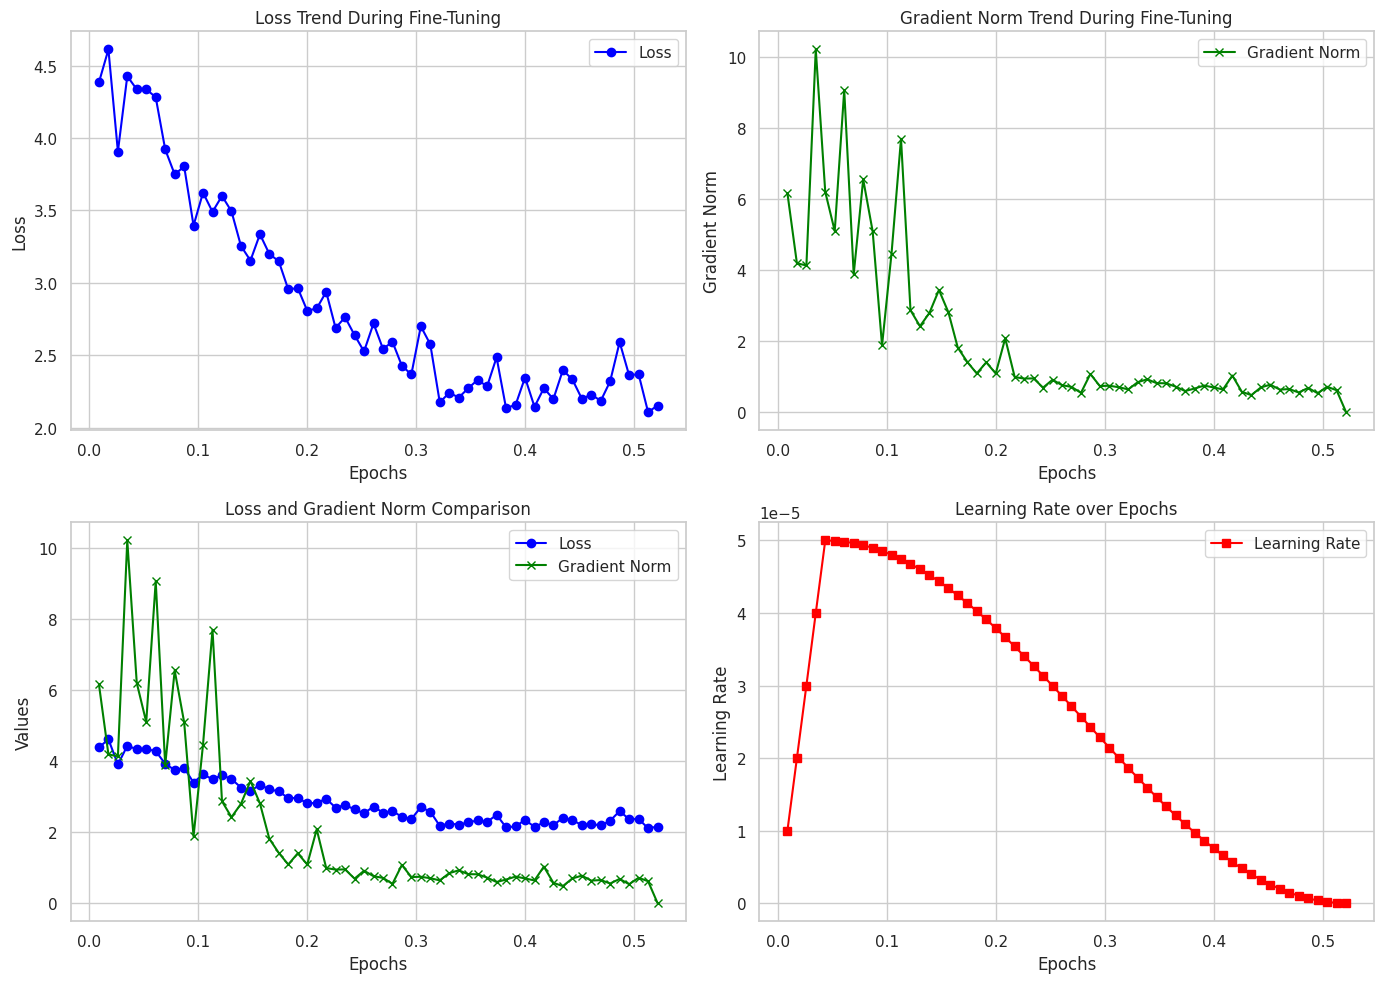

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data extracted from the log file in finetuning process
data = {
    "epoch": [
        0.0087, 0.0174, 0.0261, 0.0347, 0.0434, 0.0521, 0.0608, 0.0695, 0.0782, 0.0869,
        0.0955, 0.1042, 0.1129, 0.1216, 0.1303, 0.1390, 0.1477, 0.1564, 0.1650, 0.1737,
        0.1824, 0.1911, 0.1998, 0.2085, 0.2172, 0.2258, 0.2345, 0.2432, 0.2519, 0.2606,
        0.2693, 0.2780, 0.2866, 0.2953, 0.3040, 0.3127, 0.3214, 0.3301, 0.3388, 0.3474,
        0.3561, 0.3648, 0.3735, 0.3822, 0.3910, 0.3996, 0.4083, 0.4169, 0.4256, 0.4343,
        0.4430, 0.4517, 0.4604, 0.4691, 0.4777, 0.4864, 0.4951, 0.5038, 0.5125, 0.5212
    ],
    "learning_rate": [
        1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 4.9959e-5, 4.9837e-5, 4.9634e-5, 4.9350e-5, 4.8987e-5,
        4.8546e-5, 4.8028e-5, 4.7435e-5, 4.6769e-5, 4.6031e-5, 4.5225e-5, 4.4354e-5, 4.3419e-5,
        4.2423e-5, 4.1372e-5, 4.0266e-5, 3.9111e-5, 3.7910e-5, 3.6667e-5, 3.5385e-5, 3.4070e-5,
        3.2725e-5, 3.1355e-5, 2.9965e-5, 2.8558e-5, 2.7139e-5, 2.5714e-5, 2.4286e-5, 2.2861e-5,
        2.1442e-5, 2.0035e-5, 1.8645e-5, 1.7275e-5, 1.5930e-5, 1.4615e-5, 1.3333e-5, 1.2090e-5,
        1.0889e-5, 9.7338e-6, 8.6285e-6, 7.5766e-6, 6.5815e-6, 5.6465e-6, 4.7746e-6, 3.9687e-6,
        3.2313e-6, 2.5650e-6, 1.9719e-6, 1.4539e-6, 1.0127e-6, 6.4970e-7, 3.6615e-7, 1.6296e-7,
        4.0772e-8, 0.0
    ],
    "grad_norm": [
        6.1603, 4.1888, 4.1305, 10.2107, 6.2001, 5.0988, 9.0627, 3.8828, 6.5522, 5.0887,
        1.8783, 4.4652, 7.6956, 2.8678, 2.4190, 2.7953, 3.4389, 2.8084, 1.8133, 1.4132,
        1.0876, 1.4023, 1.0875, 2.0776, 0.9871, 0.9441, 0.9503, 0.6894, 0.9114, 0.7589,
        0.7100, 0.5425, 1.0736, 0.7344, 0.7426, 0.7011, 0.6397, 0.8438, 0.9235, 0.8157,
        0.8116, 0.7180, 0.5941, 0.6631, 0.7480, 0.6949, 0.6388, 1.0285, 0.5707, 0.4788,
        0.6948, 0.7734, 0.6338, 0.6494, 0.5522, 0.6817, 0.5327, 0.7134, 0.6168, 0.0
    ],
    "loss": [
        4.3838, 4.6111, 3.9064, 4.4265, 4.3360, 4.3369, 4.2810, 3.9211, 3.7489, 3.8035,
        3.3955, 3.6228, 3.4904, 3.5999, 3.4938, 3.2548, 3.1541, 3.3355, 3.2002, 3.1487,
        2.9548, 2.9642, 2.8075, 2.8234, 2.9380, 2.6885, 2.7626, 2.6397, 2.5265, 2.7197,
        2.5444, 2.5928, 2.4282, 2.3676, 2.7002, 2.5758, 2.1751, 2.2413, 2.2084, 2.2715,
        2.3305, 2.2852, 2.4856, 2.1347, 2.1587, 2.3462, 2.1445, 2.2729, 2.1976, 2.3972,
        2.3338, 2.2003, 2.2284, 2.1857, 2.3202, 2.5913, 2.3619, 2.3697, 2.1077, 2.1533
    ]
}

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss over Epochs
axs[0, 0].plot(df['epoch'], df['loss'], label='Loss', color='blue', marker='o')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Loss Trend During Fine-Tuning')
axs[0, 0].grid(True)

# Plot Gradient Norm over Epochs
axs[0, 1].plot(df['epoch'], df['grad_norm'], label='Gradient Norm', color='green', marker='x')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Gradient Norm')
axs[0, 1].set_title('Gradient Norm Trend During Fine-Tuning')
axs[0, 1].grid(True)

# Plot Loss and Gradient Norm for comparison
axs[1, 0].plot(df['epoch'], df['loss'], label='Loss', color='blue', marker='o')
axs[1, 0].plot(df['epoch'], df['grad_norm'], label='Gradient Norm', color='green', marker='x')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Values')
axs[1, 0].set_title('Loss and Gradient Norm Comparison')
axs[1, 0].grid(True)

## Plot Learning Rate over Epochs
axs[1, 1].plot(df['epoch'], df['learning_rate'], label='Learning Rate', color='red', marker='s')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Learning Rate')
axs[1, 1].set_title('Learning Rate over Epochs')
axs[1, 1].grid(True)

# Add legends for all subplots
for ax in axs.flat:
    ax.legend()

# Adjust layout and save the figure as PNG
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/lora_fine_tuning_metrics.png', dpi=300)  # Save the figure as PNG
plt.show()


In [ ]:
# Save the fine-tuned model with LoRA adapters
model.save_pretrained("/content/drive/MyDrive/NLX Data/lora/finetuned_model3")
tokenizer.save_pretrained("/content/drive/MyDrive/NLX Data/lora/finetuned_model3")


('/content/drive/MyDrive/NLX Data/lora/finetuned_model3/tokenizer_config.json',
 '/content/drive/MyDrive/NLX Data/lora/finetuned_model3/special_tokens_map.json',
 '/content/drive/MyDrive/NLX Data/lora/finetuned_model3/tokenizer.model',
 '/content/drive/MyDrive/NLX Data/lora/finetuned_model3/added_tokens.json',
 '/content/drive/MyDrive/NLX Data/lora/finetuned_model3/tokenizer.json')

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load the tokenizer for the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/NLX Data/lora/finetuned_model3")

# Reload the base model (causal LM) before applying LoRA adapters
model = AutoModelForCausalLM.from_pretrained("unsloth/Phi-3.5-mini-instruct")

# Load the fine-tuned LoRA adapters and apply them to the base model
model = PeftModel.from_pretrained(model, "/content/drive/MyDrive/NLX Data/lora/finetuned_model3")

# Set the model to evaluation mode
model.eval()

print("Model and tokenizer loaded with LoRA adapters applied and set to evaluation mode.")


In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
import time
import torch

# Load the fine-tuned model and tokenizer
finetuned_model_path = "/content/drive/MyDrive/NLX Data/lora/finetuned_model3"

# Load the base model (use FastLanguageModel)
model_base, tokenizer_base = FastLanguageModel.from_pretrained(
    model_name="unsloth/Phi-3.5-mini-instruct",
    max_seq_length=2048,
    dtype=None,  # Use default dtype for automatic detection
    load_in_4bit=False  # Disable 4-bit quantization to ensure compatibility
)

# Load the fine-tuned model with LoRA adapters using FastLanguageModel
model_lora = FastLanguageModel.get_peft_model(
    model_base,
    r=16,  # Same as during training
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,  # Same as during training
    bias="none",
    random_state=3407,
    loftq_config=None
)

# Set the model to evaluation mode and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lora = model_lora.to(device)
model_lora.eval()

# Ensure the tokenizer has distinct padding tokens
if tokenizer_base.pad_token is None or tokenizer_base.pad_token == tokenizer_base.eos_token:
    tokenizer_base.add_special_tokens({'pad_token': '[PAD]'})

# Apply the chat template for conversation-style input
tokenizer = get_chat_template(
    tokenizer_base,
    chat_template="phi-3",  # Custom chat template for Phi-3
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
)

# Prepare the input using the chat template (from 'Job Query' and 'Job Description' columns)
sample_data = train_dataset[5]  # Select the 5th example from the dataset
conversations = [
    {"from": "human", "value": sample_data["Job Query"].strip()},
    {"from": "gpt", "value": sample_data["Job Description"].strip()}
]

# Apply the chat template to format the conversation
formatted_input = tokenizer.apply_chat_template(conversations, tokenize=False, add_generation_prompt=True)

# Now, tokenize the formatted input
tokenized_input = tokenizer(
    formatted_input,  # The formatted conversation from chat template
    return_tensors="pt",  # Return PyTorch tensors
    padding=True,  # Pad to the longest sequence in the batch
    truncation=True,  # Truncate to the maximum sequence length
    max_length=2048,  # Max sequence length
    add_special_tokens=True  # Add special tokens
)

# Move tokenized input to the correct device
input_ids = tokenized_input["input_ids"].to(device)
attention_mask = tokenized_input["attention_mask"].to(device)

# Prepare the model for inference (for Unsloth models with LoRA)
FastLanguageModel.for_inference(model_lora)  # Necessary for Unsloth models

# Start timing before running inference
start_time = time.time()

# Run the model with the input and generate a response
outputs = model_lora.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_new_tokens=64,  # Adjust this to control the length of the generated response
    use_cache=True
)

# End timing after inference is done
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"\nTime taken to generate the response: {elapsed_time:.2f} seconds")

# Decode the model's output
decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print("\nGenerated Response: ", decoded_outputs)

# Optionally, print the original formatted text (Job Query and Job Description)
print("\nOriginal Formatted Text: ", formatted_input)


==((====))==  Unsloth 2024.9.post4: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]


Time taken to generate the response: 3.83 seconds

Generated Response:  ["Give me the information of available jobs in finland. Job available in finland\nJob-Title: senior frontend developereloper\nSalary: over $150K\nDescription:  Senior frontend location remote helsinki salary 9000 depends on years of experience . 5 years of frontend experience experience working with react js typescript and next js . While I can't provide real-time job listings, I can guide you on how to find available jobs in Finland:\n\n1. **Job Boards:**\n   - Indeed.com\n   - LinkedIn\n   - Glassdoor\n   - Monster.com\n\n2."]

Original Formatted Text:  <|user|>
Give me the information of available jobs in finland.<|end|>
<|assistant|>
Job available in finland
Job-Title: senior frontend developereloper
Salary: over $150K
Description:  Senior frontend location remote helsinki salary 9000 depends on years of experience . 5 years of frontend experience experience working with react js typescript and next js .<|end|

#### Test Chat with 4 Job-Based Queries

In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
import time
import torch

# Load the fine-tuned model and tokenizer
finetuned_model_path = "/content/drive/MyDrive/NLX Data/lora/finetuned_model3"

# Load the base model (use FastLanguageModel)
model_base, tokenizer_base = FastLanguageModel.from_pretrained(
    model_name="unsloth/Phi-3.5-mini-instruct",
    max_seq_length=2048,
    dtype=None,  # Use default dtype for automatic detection
    load_in_4bit=False  # Disable 4-bit quantization to ensure compatibility
)

# Load the fine-tuned model with LoRA adapters using FastLanguageModel
model_lora = FastLanguageModel.get_peft_model(
    model_base,
    r=16,  # Same as during training
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,  # Same as during training
    bias="none",
    random_state=3407,
    loftq_config=None
)

# Set the model to evaluation mode and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lora = model_lora.to(device)
model_lora.eval()

# Ensure the tokenizer has distinct padding tokens
if tokenizer_base.pad_token is None or tokenizer_base.pad_token == tokenizer_base.eos_token:
    tokenizer_base.add_special_tokens({'pad_token': '[PAD]'})

# Apply the chat template for conversation-style input
tokenizer = get_chat_template(
    tokenizer_base,
    chat_template="phi-3",  # Custom chat template for Phi-3
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
)

# Define the four queries
queries = [
    "What roles are available for machine learning engineer?",
    "What jobs are open in finland?",
    "Which jobs pay over $150K?",
    "What jobs are available for passionate python developer with 5 years of experience?"
]

# Function to generate a response for a query
def generate_response(query):
    # Prepare the input using the chat template for the current query
    conversations = [{"from": "human", "value": query}]
    formatted_input = tokenizer.apply_chat_template(conversations, tokenize=False, add_generation_prompt=True)

    # Tokenize the input
    tokenized_input = tokenizer(
        formatted_input,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=2048,
        add_special_tokens=True
    )

    # Move tokenized input to the correct device
    input_ids = tokenized_input["input_ids"].to(device)
    attention_mask = tokenized_input["attention_mask"].to(device)

    # Prepare the model for inference (for Unsloth models with LoRA)
    FastLanguageModel.for_inference(model_lora)

    # Start timing before running inference
    start_time = time.time()

    # Run the model with the input and generate a response
    outputs = model_lora.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=64,
        use_cache=True
    )

    # End timing after inference is done
    end_time = time.time()

    # Calculate the total time taken
    elapsed_time = end_time - start_time
    # print(f"\nTime taken to generate the response: {elapsed_time:.2f} seconds")

    # Decode the model's output
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return decoded_outputs[0], elapsed_time  # Return the decoded output

# 1. Jobs Based on Specific Skills
skill_query = "What roles are available for machine learning engineer?"
response, time_taken = generate_response(skill_query)
print(f"Skill-Based Query: {skill_query}\nResponse: {response}\nTime Taken: {time_taken:.2f} seconds\n")

# 2. Jobs in Specific Locations
location_query = "What jobs are open in finland?"
response, time_taken = generate_response(location_query)
print(f"Location-Based Query: {location_query}\nResponse: {response}\nTime Taken: {time_taken:.2f} seconds\n")

# 3. Jobs with Specific Salary Ranges
salary_query = "Which jobs pay over over $150K?"
response, time_taken = generate_response(salary_query)
print(f"Salary-Based Query: {salary_query}\nResponse: {response}\nTime Taken: {time_taken:.2f} seconds\n")

# 4. Jobs Based on Work Experience
experience_query = "What jobs are available for passionate python developer with 5 years of experience"
response, time_taken = generate_response(experience_query)
print(f"Experience-Based Query: {experience_query}\nResponse: {response}\nTime Taken: {time_taken:.2f} seconds\n")


==((====))==  Unsloth 2024.9.post4: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Skill-Based Query: What roles are available for machine learning engineer?
Response: What roles are available for machine learning engineer? As a machine learning engineer, there are a variety of roles and positions you can pursue, often depending on the industry, company size, and specific expertise. Here are some common roles and job titles you might find available:

1. Machine Learning Engineer: Responsible for designing, developing
Time Taken: 3.31 seconds

Location-Based Query: What jobs are open in finland?
Response: What jobs are open in finland? As of my knowledge cutoff in early 2023, I cannot provide real-time job listings. However, I can guide you on how to find open jobs in Finland:

1. **Job Boards:**
   - **Monster.com**: Search for Finnish job
Time Taken: 3.34 seconds

Salary-Based Query: Which jobs pay over over $150K?
Response: Which jobs pay over over $150K? Jobs that pay over $150,000 per year are typically found in specialized, high-demand fields, leadership roles, 

In [ ]:
# Inference on the base model (before fine-tuning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate responses for the job queries
def generate_responses(queries, max_new_tokens=64):
    generated_responses = []

    for query in queries:
        # Prepare the input as expected by the model
        messages = [{"from": "human", "value": query}]

        # Start the timer
        start_time = time.time()

        # Tokenize the input with the template
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
            add_eos_token=True
        )

        # Check the structure of inputs
        if isinstance(inputs, dict):
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
        else:
            input_ids = inputs.to(device)
            attention_mask = None  # If attention mask is not returned, set it to None

        # Generate output
        outputs = model_lora.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,  # Can be None if not provided
            max_new_tokens=64,
            use_cache=True
        )

        # Stop the timer
        end_time = time.time()

        # Calculate the time taken
        time_taken = end_time - start_time

        # Decode the generated output
        decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        generated_responses.append(decoded_output)

    return generated_responses, time_taken

# Example job queries
job_queries = [
    "What jobs are available for Python developers?",
    "Show me jobs in New York."
]

# Run the inference
generated_descriptions, time_taken = generate_responses(job_queries)

print(f"Time taken to generate the response: {time_taken:.2f} seconds")

# Print generated responses
for i, description in enumerate(generated_descriptions):
    print(f"Query: {job_queries[i]}")
    print(f"Generated Job Description: {description}")
    print("-" * 50)

Time taken to generate the response: 3.32 seconds
Query: What jobs are available for Python developers?
Generated Job Description: What jobs are available for Python developers? Python developers can find a wide range of job opportunities due to the popularity and versatility of the Python programming language. Here are some common job roles and industries where Python developers can work:

1. Software Developer: Python developers can work on various software projects, including web applications, desktop applications
--------------------------------------------------
Query: Show me jobs in New York.
Generated Job Description: Show me jobs in New York. To show you jobs in New York, I would typically use job search platforms, company career pages, or professional networking sites. Here's a step-by-step guide on how to find job listings in New York:

1. **LinkedIn:**
   - Go to LinkedIn.
--------------------------------------------------


## Lora Model Evaluation

In [ ]:
import time
from bert_score import score
from rouge_score import rouge_scorer
import evaluate

# Generate response
from transformers import TextStreamer

# Load BLEU metric
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

# Function to generate response and calculate scores
def generate_and_score(prompt, reference):

    # Start the timer
    start_time = time.time()

    # Prepare input for inference
    messages = [
        {"from": "human", "value": prompt},
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt",
    ).to("cuda")

    # Generate response
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)

    output_ids = model_lora.generate(input_ids = inputs, max_new_tokens = 128, use_cache = True)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Calculate BERT Score
    P, R, F1 = score([generated_text], [reference], lang="en", verbose=False)
    bert_score = F1.item()

    # Calculate ROUGE Score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated_text)

    # Calculate BLEU Score
    predictions = [generated_text]
    references = [[reference]]
    bleu_results = bleu.compute(predictions=predictions, references=references)
    bleu_score = bleu_results['bleu']

    # Calculate METEOR Score
    meteor_results = meteor.compute(predictions=predictions, references=[reference])
    meteor_score = meteor_results['meteor']

    # Print results
    print(f"\nGenerated Text: {generated_text}")
    print(f"\nEvaluation Metric for Salary-Based Question:")
    print(f">> BERT Score: {bert_score}")
    print(f">> ROUGE Scores: {rouge_scores}")
    print(f">> BLEU Score: {bleu_score}")
    print(f">> METEOR Score: {meteor_score}")

    # Stop the timer
    end_time = time.time()

    # Calculate the time taken
    time_taken = end_time - start_time

    return generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken

# Example usage
prompt = "Which jobs pay over over $150K?"
reference = 'Job available with a salary of over $150K Location: calgary, ab Job-Title: intermediate full stack developereloper Description:  The intermediate full stack developer contributes to all aspects of the sldc process . The candidate must have a bachelor s degree in computer science . The position will be contacted powered by jazzhr bue7wjcxw1'

generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken = generate_and_score(prompt, reference)

print(f"Time taken to generate the response: {time_taken:.2f} seconds")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Generated Text: Which jobs pay over over $150K? Jobs that pay over $150,000 per year are typically found in specialized, high-demand fields, leadership roles, or industries with significant capital investment. Here's a list of some high-paying job categories and specific roles within them:

1. **Executive and Senior Management:**
   - Chief Executive Officer (CEO)
   - President
   - Senior Vice President
   - General Manager
   - Chief Financial Officer (CFO)
   - Chief Operating Officer (COO)
   - Chief Technology Officer (CTO

Evaluation Metric for Salary-Based Question:
>> BERT Score: 0.7852854132652283
>> ROUGE Scores: {'rouge1': Score(precision=0.125, recall=0.17647058823529413, fmeasure=0.14634146341463414), 'rouge2': Score(precision=0.014084507042253521, recall=0.02, fmeasure=0.01652892561983471), 'rougeL': Score(precision=0.06944444444444445, recall=0.09803921568627451, fmeasure=0.08130081300813008)}
>> BLEU Score: 0.0
>> METEOR Score: 0.1376296420207427
Time taken to generat

In [ ]:
import time
from bert_score import score
from rouge_score import rouge_scorer
import evaluate

# Load BLEU and METEOR metrics
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

# Function to generate response and calculate scores for a prompt
def generate_and_score(prompt, reference):

    # Start the timer
    start_time = time.time()

    # Prepare input for inference
    messages = [
        {"from": "human", "value": prompt},
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # Generate response
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)

    output_ids = model_lora.generate(input_ids = inputs, max_new_tokens = 128, use_cache = True)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Calculate BERT Score
    P, R, F1 = score([generated_text], [reference], lang="en", verbose=False)
    bert_score = F1.item()

    # Calculate ROUGE Score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated_text)

    # Calculate BLEU Score
    predictions = [generated_text]
    references = [[reference]]
    bleu_results = bleu.compute(predictions=predictions, references=references)
    bleu_score = bleu_results['bleu']

    # Calculate METEOR Score
    meteor_results = meteor.compute(predictions=predictions, references=[reference])
    meteor_score = meteor_results['meteor']

    # Stop the timer
    end_time = time.time()
    time_taken = end_time - start_time

    return generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken

# Function to evaluate multiple queries
def evaluate_queries(queries_and_references):
    results = []
    for query_type, query_info in queries_and_references.items():
        prompt, reference = query_info['prompt'], query_info['reference']
        print(f"\nEvaluating {query_type} query: {prompt}")
        generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken = generate_and_score(prompt, reference)
        results.append({
            'query_type': query_type,
            'prompt': prompt,
            'generated_text': generated_text,
            'bert_score': bert_score,
            'rouge_scores': rouge_scores,
            'bleu_score': bleu_score,
            'meteor_score': meteor_score,
            'time_taken': time_taken
        })
    return results

# Example queries and references
queries_and_references = {
    'skills': {
        'prompt': "What roles are available for machine learning engineer?",
        'reference': 'Job available in Location: quÃ©bec city, qc Salary: over $150K Job-Title: senior machine learning engineer Description:  vivun is the world s leading provider of presales software our ai powered platform includes solutions for presales operations demo automation and aligning sales with product teams . The position will be responsible for developing and maintaining the end to end architecture deployment and monitoring of multiple ai ml solutions.'
        },
    'salary': {
        'prompt': "Which jobs pay over over $150K?",
        'reference': 'Job available with a salary of over $150K Location: calgary, ab Job-Title: intermediate full stack developereloper Description:  The intermediate full stack developer contributes to all aspects of the sldc process . The candidate must have a bachelor s degree in computer science . The position will be contacted powered by jazzhr bue7wjcxw1.'
        },
    'experience': {
        'prompt': "What jobs are available for passionate python developer with 5 years of experience?",
        'reference': 'Job available in Location: san francisco, ca, united states Salary: over $75K and under $150K Job-Title: entry level python developereloper Description:  The job market is challenging and to stand out you need to have exceptional skills and technologies . We are looking for entry level software programmers it enthusiasts python java developers data analysts data scientists who should apply recent computer science engineering mathematics statistics or science graduates looking to make their careers in it industry . We welcome candidates with all visas and citizens to apply .'
        },
    'location': {
	      'prompt': "What jobs are open in finland?",
        'reference': 'Job available in finland Job-Title: senior frontend developereloper Salary: over $150K Description:  Senior frontend location remote helsinki salary 9000 depends on years of experience . 5 years of frontend experience experience working with react js typescript and next js .'
        }
}

# Evaluate all queries
evaluation_results = evaluate_queries(queries_and_references)

# Initialize lists to store metrics for each query type
query_types = []
bert_scores = []
rouge1_f1 = []
rouge2_f1 = []
rougeL_f1 = []
bleu_scores = []
meteor_scores = []
time_taken = []
query_length = [8, 6, 15, 6] # the length of query for sample

# Assuming `evaluation_results` is a list of dictionaries containing the evaluation results
for result in evaluation_results:
    # Append the query type
    query_types.append(result['query_type'].capitalize())

    # Append the individual metrics dynamically
    bert_scores.append(result['bert_score'])
    rouge1_f1.append(result['rouge_scores']['rouge1'].fmeasure)
    rouge2_f1.append(result['rouge_scores']['rouge2'].fmeasure)
    rougeL_f1.append(result['rouge_scores']['rougeL'].fmeasure)
    bleu_scores.append(result['bleu_score'])
    meteor_scores.append(result['meteor_score'])
    time_taken.append(result['time_taken'])  # In seconds

# Print the dynamically created lists
print("\nQuery Types:", query_types)
print("BERT Scores:", bert_scores)
print("ROUGE-1 F1 Scores:", rouge1_f1)
print("ROUGE-2 F1 Scores:", rouge2_f1)
print("ROUGE-L F1 Scores:", rougeL_f1)
print("BLEU Scores:", bleu_scores)
print("METEOR Scores:", meteor_scores)
print("Time Taken:", time_taken)


In [ ]:
import time
import pandas as pd
from bert_score import score
from rouge_score import rouge_scorer
import evaluate

# Load BLEU and METEOR metrics
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

# Define model name
modname = "lora"

# Function to generate response and calculate scores for a prompt
def generate_and_score(prompt, reference):

    # Start the timer
    start_time = time.time()

    # Prepare input for inference
    messages = [{"from": "human", "value": prompt}]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # Generate response
    output_ids = model_lora.generate(input_ids=inputs, max_new_tokens=128, use_cache=True)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Calculate BERT Score
    P, R, F1 = score([generated_text], [reference], lang="en", verbose=False)
    bert_score = F1.item()

    # Calculate ROUGE Score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated_text)

    # Calculate BLEU Score
    predictions = [generated_text]
    references = [[reference]]
    bleu_results = bleu.compute(predictions=predictions, references=references)
    bleu_score = bleu_results['bleu']

    # Calculate METEOR Score
    meteor_results = meteor.compute(predictions=predictions, references=[reference])
    meteor_score = meteor_results['meteor']

    # Stop the timer
    end_time = time.time()
    time_taken = end_time - start_time

    # Compute query length
    query_length = len(prompt.split())

    return generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken, query_length

# Function to evaluate multiple queries
def evaluate_queries(queries_and_references):
    results = []
    for query_type, query_info in queries_and_references.items():
        prompt, reference = query_info['prompt'], query_info['reference']
        print(f"\nEvaluating {query_type} query: {prompt}")
        generated_text, bert_score, rouge_scores, bleu_score, meteor_score, time_taken, query_length = generate_and_score(prompt, reference)
        results.append({
            'query_type': query_type,
            'prompt': prompt,
            'generated_text': generated_text,
            'bert_score': bert_score,
            'rouge_scores': rouge_scores,
            'bleu_score': bleu_score,
            'meteor_score': meteor_score,
            'time_taken': time_taken,
            'query_length': query_length
        })
    return results

# Example queries and references
queries_and_references = {
    'skills': {
        'prompt': "What roles are available for machine learning engineer?",
        'reference': 'Job available in Location: quÃ©bec city, qc Salary: over $150K Job-Title: senior machine learning engineer ...'
        },
    'salary': {
        'prompt': "Which jobs pay over over $150K?",
        'reference': 'Job available with a salary of over $150K Location: calgary, ab Job-Title: intermediate full stack developer ...'
        },
    'experience': {
        'prompt': "What jobs are available for passionate python developer with 5 years of experience?",
        'reference': 'Job available in Location: san francisco, ca, united states Salary: over $75K and under $150K Job-Title: entry level python developer ...'
        },
    'location': {
	      'prompt': "What jobs are open in finland?",
        'reference': 'Job available in finland Job-Title: senior frontend developer Salary: over $150K ...'
        }
}

# Evaluate all queries
evaluation_results = evaluate_queries(queries_and_references)

# Initialize lists to store metrics for each query type
query_types = []
bert_scores = []
rouge1_f1 = []
rouge2_f1 = []
rougeL_f1 = []
bleu_scores = []
meteor_scores = []
time_taken = []
query_lengths = []

# Append metrics into the data list to save into CSV
data = []

for result in evaluation_results:
    query_type = result['query_type'].capitalize()
    query_length = result['query_length']

    # Store metrics for printing later
    query_types.append(query_type)
    bert_scores.append(result['bert_score'])
    rouge1_f1.append(result['rouge_scores']['rouge1'].fmeasure)
    rouge2_f1.append(result['rouge_scores']['rouge2'].fmeasure)
    rougeL_f1.append(result['rouge_scores']['rougeL'].fmeasure)
    bleu_scores.append(result['bleu_score'])
    meteor_scores.append(result['meteor_score'])
    time_taken.append(result['time_taken'])
    query_lengths.append(query_length)

    # Prepare data for CSV
    data.append([modname, query_type, "bert", result['bert_score'], query_length])
    data.append([modname, query_type, "rouge1_f1", result['rouge_scores']['rouge1'].fmeasure, query_length])
    data.append([modname, query_type, "rouge2_f1", result['rouge_scores']['rouge2'].fmeasure, query_length])
    data.append([modname, query_type, "rougeL_f1", result['rouge_scores']['rougeL'].fmeasure, query_length])
    data.append([modname, query_type, "bleu", result['bleu_score'], query_length])
    data.append([modname, query_type, "meteor", result['meteor_score'], query_length])

# Convert the data into a DataFrame and save to CSV
df = pd.DataFrame(data, columns=["model", "query", "metrics", "score", "query_length"])
df.to_csv(f'/content/drive/MyDrive/NLX Data/data/{modname}_metrics.csv', index=False)

# Print the dynamically created lists for screen output
print("\nQuery Types:", query_types)
print("Query Lengths:", query_lengths)
print("BERT Scores:", bert_scores)
print("ROUGE-1 F1 Scores:", rouge1_f1)
print("ROUGE-2 F1 Scores:", rouge2_f1)
print("ROUGE-L F1 Scores:", rougeL_f1)
print("BLEU Scores:", bleu_scores)
print("METEOR Scores:", meteor_scores)
print("Time Taken (seconds):", time_taken)

# Confirmation of CSV save
print(f"\nEvaluation results saved to {modname}_metrics.csv.")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Evaluating skills query: What roles are available for machine learning engineer?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluating salary query: Which jobs pay over over $150K?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluating experience query: What jobs are available for passionate python developer with 5 years of experience?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluating location query: What jobs are open in finland?


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Query Types: ['Skills', 'Salary', 'Experience', 'Location']
Query Lengths: [8, 6, 13, 6]
BERT Scores: [0.8167415261268616, 0.8018397688865662, 0.8066660165786743, 0.8007366061210632]
ROUGE-1 F1 Scores: [0.10909090909090909, 0.15730337078651685, 0.13114754098360656, 0.09302325581395349]
ROUGE-2 F1 Scores: [0.055555555555555546, 0.02298850574712644, 0.03333333333333333, 0.023809523809523808]
ROUGE-L F1 Scores: [0.10909090909090909, 0.11235955056179774, 0.11475409836065575, 0.09302325581395349]
BLEU Scores: [0.0, 0.0, 0.0, 0.0]
METEOR Scores: [0.1959565829811915, 0.22220279720279715, 0.13368983957219252, 0.15183673469387757]
Time Taken (seconds): [7.630907297134399, 7.591222047805786, 7.673969507217407, 7.614568710327148]

Evaluation results saved to lora_metrics.csv.


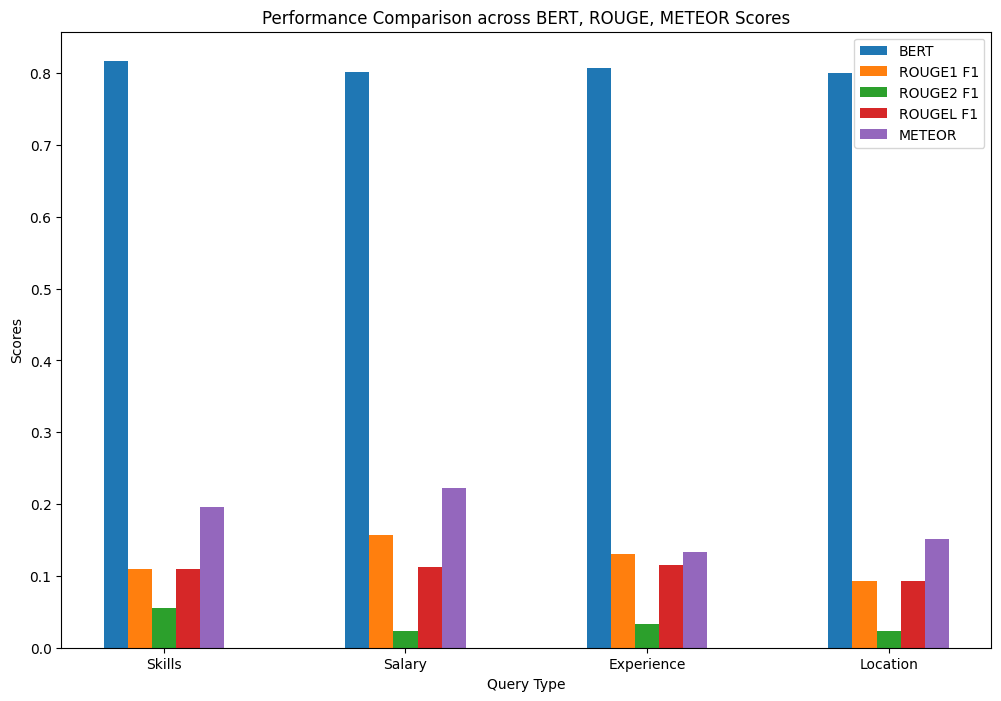

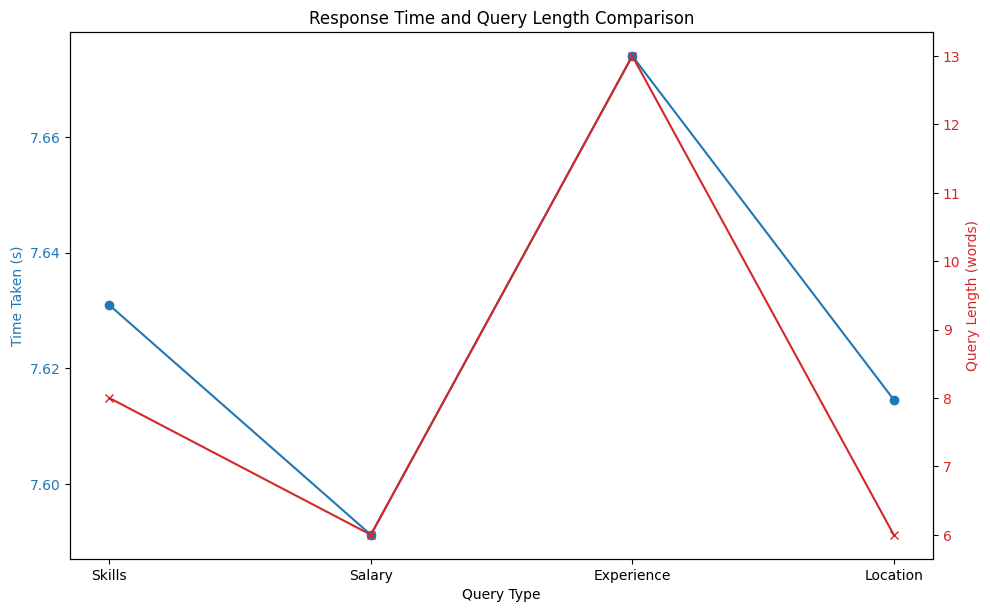

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np


# Bar Chart: BERT, ROUGE1, ROUGE2, ROUGEL, BLEU, METEOR Comparison
def plot_metric_comparison(modname):
    width = 0.1  # width of bars
    ind = np.arange(len(query_types))  # the x locations for the groups

    plt.figure(figsize=(12, 8))

    # Bar plots for BERT, ROUGE1, ROUGE2, ROUGEL, BLEU, METEOR scores
    plt.bar(ind - width*2, bert_scores, width, label='BERT')
    plt.bar(ind - width, rouge1_f1, width, label='ROUGE1 F1')
    plt.bar(ind, rouge2_f1, width, label='ROUGE2 F1')
    plt.bar(ind + width, rougeL_f1, width, label='ROUGEL F1')
    plt.bar(ind + width*2, meteor_scores, width, label='METEOR')

    plt.xlabel('Query Type')
    plt.ylabel('Scores')
    plt.title('Performance Comparison across BERT, ROUGE, METEOR Scores')
    plt.xticks(ind, query_types)
    plt.legend(loc='best')

    plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_metrics_comparison.png')
    plt.show()

# Line Graph: Response Time and Query Length Comparison
def plot_time_and_length_comparison(modname):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Query Type')
    ax1.set_ylabel('Time Taken (s)', color=color)
    ax1.plot(query_types, time_taken, marker='o', color=color, label='Time Taken (s)')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Query Length (words)', color=color)  # we already handled the x-label with ax1
    ax2.plot(query_types, query_lengths, marker='x', color=color, label='Query Length')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # to ensure the two axes don't overlap
    plt.title('Response Time and Query Length Comparison')
    plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_respontime_vs_querylength.png')
    plt.show()

# Call plotting functions
plot_metric_comparison(modname)
plot_time_and_length_comparison(modname)


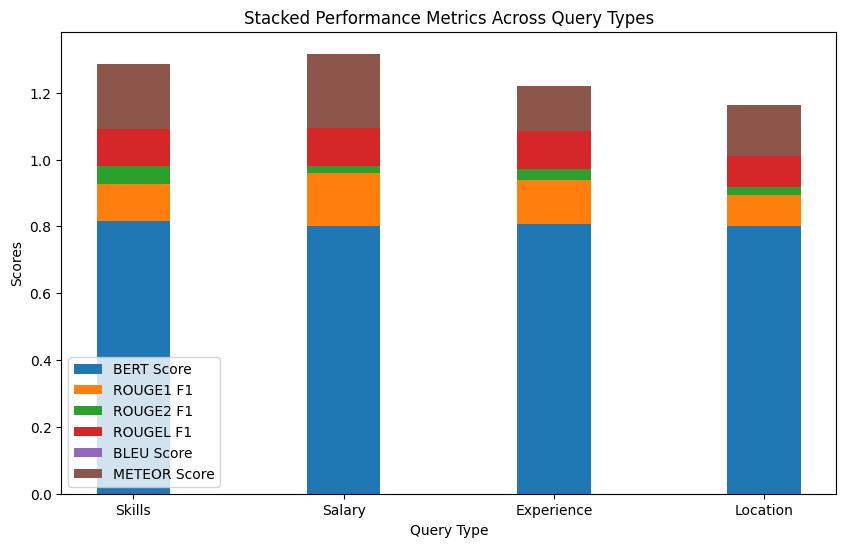

In [ ]:
# Stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the bars and positions
bar_width = 0.35
ind = np.arange(len(query_types))

# Stacking each metric
bar1 = ax.bar(ind, bert_scores, bar_width, label='BERT Score')
bar2 = ax.bar(ind, rouge1_f1, bar_width, bottom=bert_scores, label='ROUGE1 F1')
bar3 = ax.bar(ind, rouge2_f1, bar_width, bottom=np.array(bert_scores) + np.array(rouge1_f1), label='ROUGE2 F1')
bar4 = ax.bar(ind, rougeL_f1, bar_width, bottom=np.array(bert_scores) + np.array(rouge1_f1) + np.array(rouge2_f1), label='ROUGEL F1')
bar5 = ax.bar(ind, bleu_scores, bar_width, bottom=np.array(bert_scores) + np.array(rouge1_f1) + np.array(rouge2_f1) + np.array(rougeL_f1), label='BLEU Score')
bar6 = ax.bar(ind, meteor_scores, bar_width, bottom=np.array(bert_scores) + np.array(rouge1_f1) + np.array(rouge2_f1) + np.array(rougeL_f1) + np.array(bleu_scores), label='METEOR Score')

# Labeling
ax.set_xlabel('Query Type')
ax.set_ylabel('Scores')
ax.set_title('Stacked Performance Metrics Across Query Types')
ax.set_xticks(ind)
ax.set_xticklabels(query_types)
ax.legend()

# Save the plot
plt.savefig(f"/content/drive/MyDrive/NLX Data/visualizations/{modname}_performance_across_query.png")
plt.show()


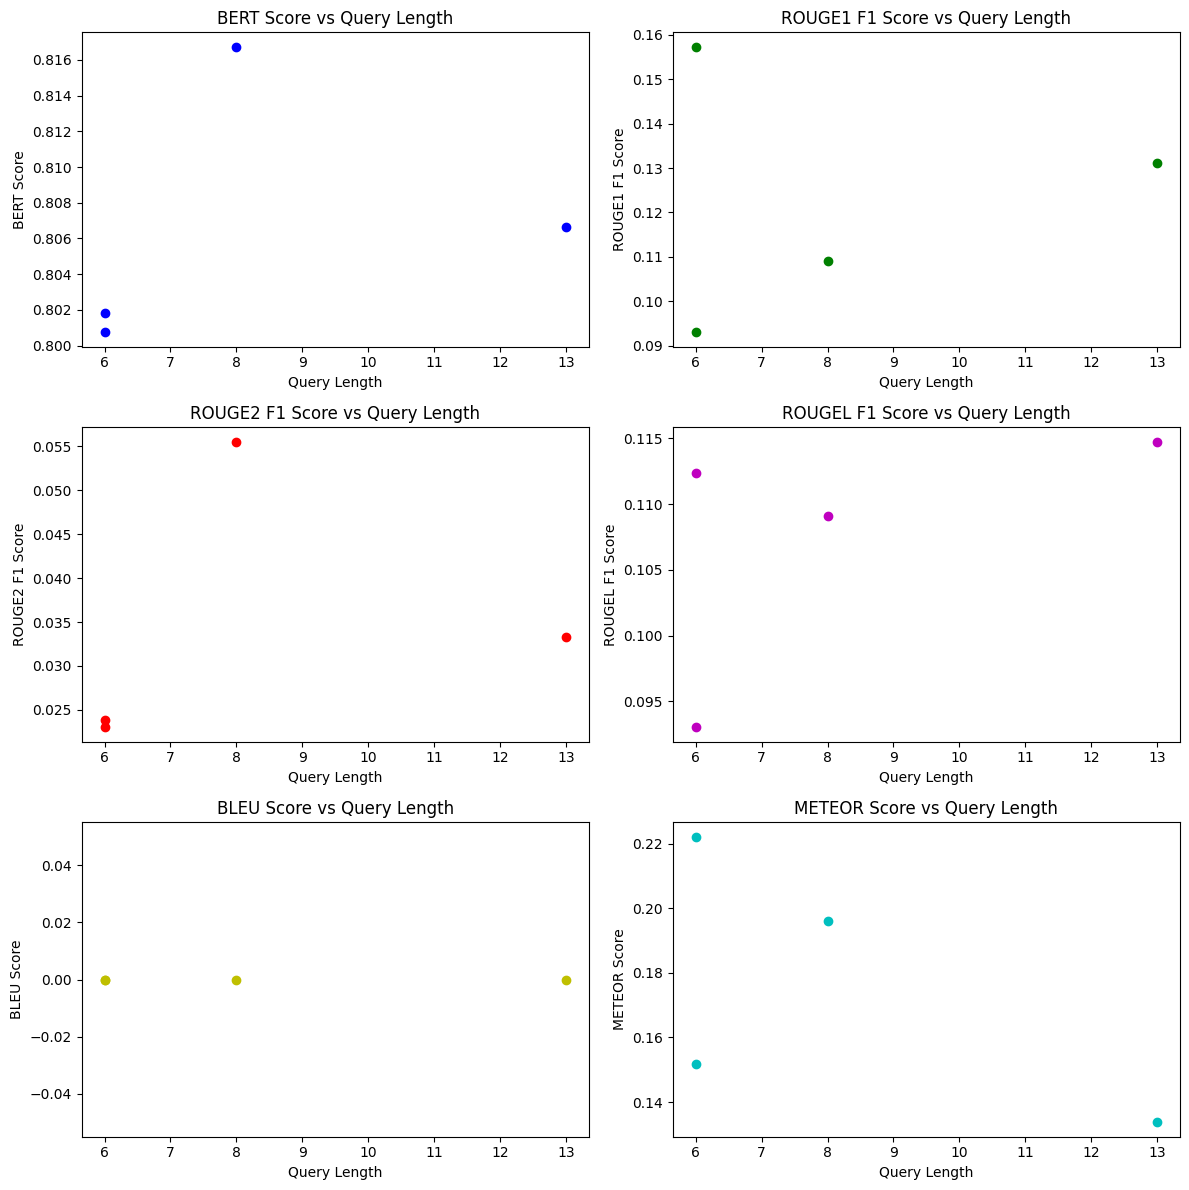

In [ ]:
# Create a figure and axis for each metric against query length
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

# BERT Score vs Query Length
ax[0, 0].scatter(query_lengths, bert_scores, color='b')
ax[0, 0].set_title('BERT Score vs Query Length')
ax[0, 0].set_xlabel('Query Length')
ax[0, 0].set_ylabel('BERT Score')

# ROUGE1 F1 vs Query Length
ax[0, 1].scatter(query_lengths, rouge1_f1, color='g')
ax[0, 1].set_title('ROUGE1 F1 Score vs Query Length')
ax[0, 1].set_xlabel('Query Length')
ax[0, 1].set_ylabel('ROUGE1 F1 Score')

# ROUGE2 F1 vs Query Length
ax[1, 0].scatter(query_lengths, rouge2_f1, color='r')
ax[1, 0].set_title('ROUGE2 F1 Score vs Query Length')
ax[1, 0].set_xlabel('Query Length')
ax[1, 0].set_ylabel('ROUGE2 F1 Score')

# ROUGEL F1 vs Query Length
ax[1, 1].scatter(query_lengths, rougeL_f1, color='m')
ax[1, 1].set_title('ROUGEL F1 Score vs Query Length')
ax[1, 1].set_xlabel('Query Length')
ax[1, 1].set_ylabel('ROUGEL F1 Score')

# BLEU Score vs Query Length
ax[2, 0].scatter(query_lengths, bleu_scores, color='y')
ax[2, 0].set_title('BLEU Score vs Query Length')
ax[2, 0].set_xlabel('Query Length')
ax[2, 0].set_ylabel('BLEU Score')

# METEOR Score vs Query Length
ax[2, 1].scatter(query_lengths, meteor_scores, color='c')
ax[2, 1].set_title('METEOR Score vs Query Length')
ax[2, 1].set_xlabel('Query Length')
ax[2, 1].set_ylabel('METEOR Score')

# Adjust layout and show plot
plt.tight_layout()

# Save the entire figure as a PNG file
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_metrics_vs_query_lengths.png', dpi=300)

plt.show()


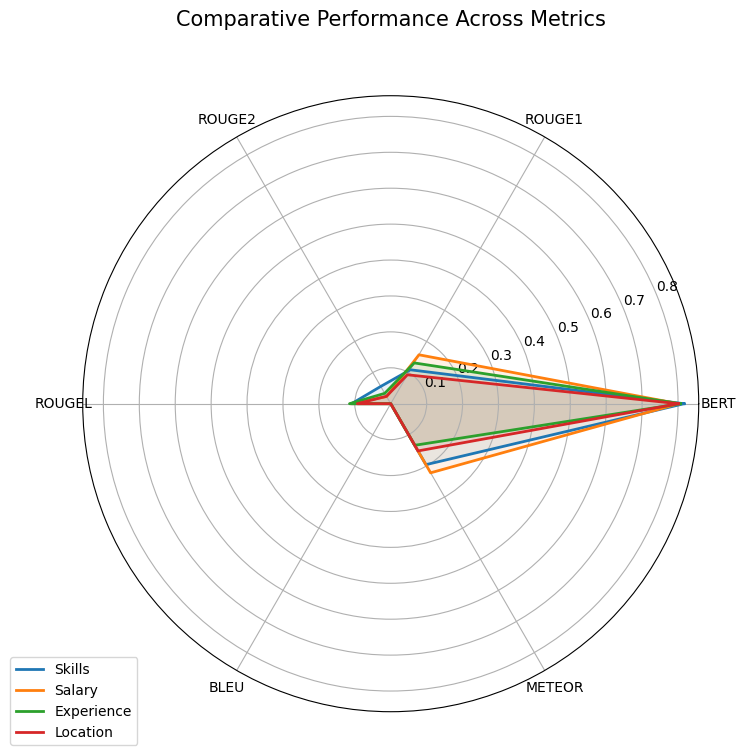

In [ ]:
# Create a radar chart
metrics = ['BERT', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'BLEU', 'METEOR']

# Prepare the data for radar chart (normalize values between 0 and 1)
data_skills = [bert_scores[0], rouge1_f1[0], rouge2_f1[0], rougeL_f1[0], bleu_scores[0], meteor_scores[0]]
data_salary = [bert_scores[1], rouge1_f1[1], rouge2_f1[1], rougeL_f1[1], bleu_scores[1], meteor_scores[1]]
data_experience = [bert_scores[2], rouge1_f1[2], rouge2_f1[2], rougeL_f1[2], bleu_scores[2], meteor_scores[2]]
data_location = [bert_scores[3], rouge1_f1[3], rouge2_f1[3], rougeL_f1[3], bleu_scores[3], meteor_scores[3]]

# Add the first metric to the end to close the radar chart circle
data_skills += data_skills[:1]
data_salary += data_salary[:1]
data_experience += data_experience[:1]
data_location += data_location[:1]

# Set up radar chart
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each query type
ax.plot(angles, data_skills, linewidth=2, linestyle='solid', label='Skills')
ax.fill(angles, data_skills, alpha=0.1)

ax.plot(angles, data_salary, linewidth=2, linestyle='solid', label='Salary')
ax.fill(angles, data_salary, alpha=0.1)

ax.plot(angles, data_experience, linewidth=2, linestyle='solid', label='Experience')
ax.fill(angles, data_experience, alpha=0.1)

ax.plot(angles, data_location, linewidth=2, linestyle='solid', label='Location')
ax.fill(angles, data_location, alpha=0.1)

# Add labels for each metric
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Add title and legend
ax.set_title("Comparative Performance Across Metrics", size=15, color="black", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Save the radar chart to a file
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_comparative_performance_radar.png')
plt.show()


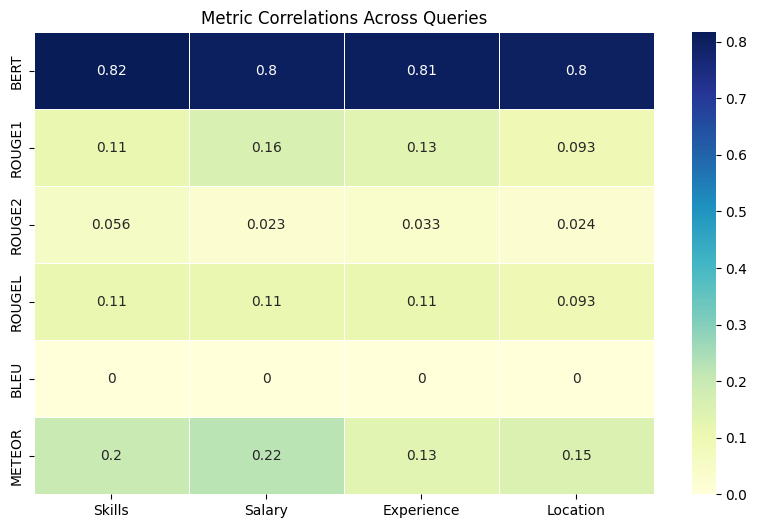

In [ ]:
data_skills = [bert_scores[0], rouge1_f1[0], rouge2_f1[0], rougeL_f1[0], bleu_scores[0], meteor_scores[0]]
data_salary = [bert_scores[1], rouge1_f1[1], rouge2_f1[1], rougeL_f1[1], bleu_scores[1], meteor_scores[1]]
data_experience = [bert_scores[2], rouge1_f1[2], rouge2_f1[2], rougeL_f1[2], bleu_scores[2], meteor_scores[2]]
data_location = [bert_scores[3], rouge1_f1[3], rouge2_f1[3], rougeL_f1[3], bleu_scores[3], meteor_scores[3]]

data = {
    'Skills': data_skills,
    'Salary': data_salary,
    'Experience': data_experience,
    'Location': data_location
}

# Metric names
metrics = ['BERT', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'BLEU', 'METEOR']

# Create a DataFrame
df = pd.DataFrame(data, index=metrics)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)

# Add title
plt.title("Metric Correlations Across Queries")

# Save the heatmap as a file
plt.savefig(f"/content/drive/MyDrive/NLX Data/visualizations/{modname}_metric_correlations_heatmap.png")

# Show the plot
plt.show()


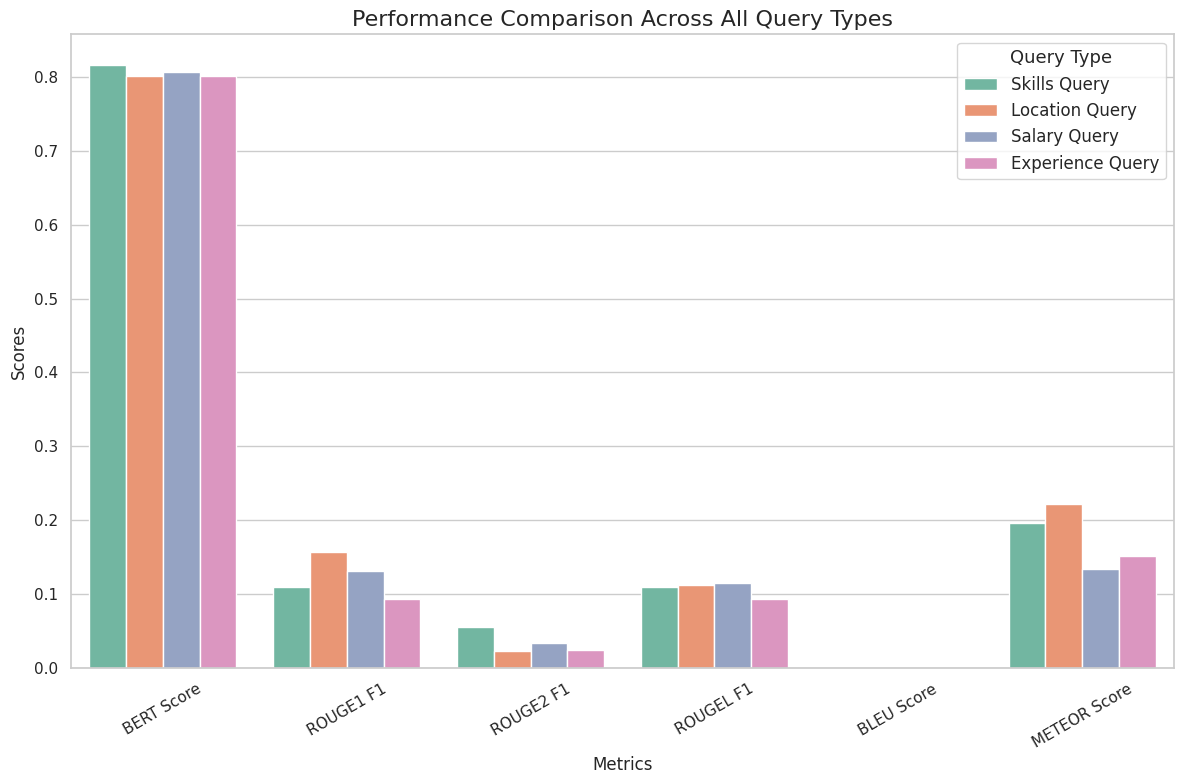

In [ ]:
# Create a dataframe for the data to make plotting easier
metrics_data = {
    'Metric': ['BERT Score', 'ROUGE1 F1', 'ROUGE2 F1', 'ROUGEL F1', 'BLEU Score', 'METEOR Score'],
    'Skills Query': [bert_scores[0], rouge1_f1[0], rouge2_f1[0], rougeL_f1[0], bleu_scores[0], meteor_scores[0]],
    'Location Query': [bert_scores[1], rouge1_f1[1], rouge2_f1[1], rougeL_f1[1], bleu_scores[1], meteor_scores[1]],
    'Salary Query': [bert_scores[2], rouge1_f1[2], rouge2_f1[2], rougeL_f1[2], bleu_scores[2], meteor_scores[2]],
    'Experience Query': [bert_scores[3], rouge1_f1[3], rouge2_f1[3], rougeL_f1[3], bleu_scores[3], meteor_scores[3]]
}

df = pd.DataFrame(metrics_data)

# Set the style for the plots
sns.set(style="whitegrid")

# Melt the dataframe for easier plotting
df_melted = df.melt(id_vars="Metric", var_name="Query Type", value_name="Score")

# Plot comparison of each metric across all query types
plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Query Type", palette="Set2")

# Customize plot
plt.title('Performance Comparison Across All Query Types', fontsize=16)
plt.ylabel('Scores', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=30)
plt.legend(title="Query Type", fontsize=12, title_fontsize='13')

# Save and show plot
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_all_query_comparison.png')
plt.show()


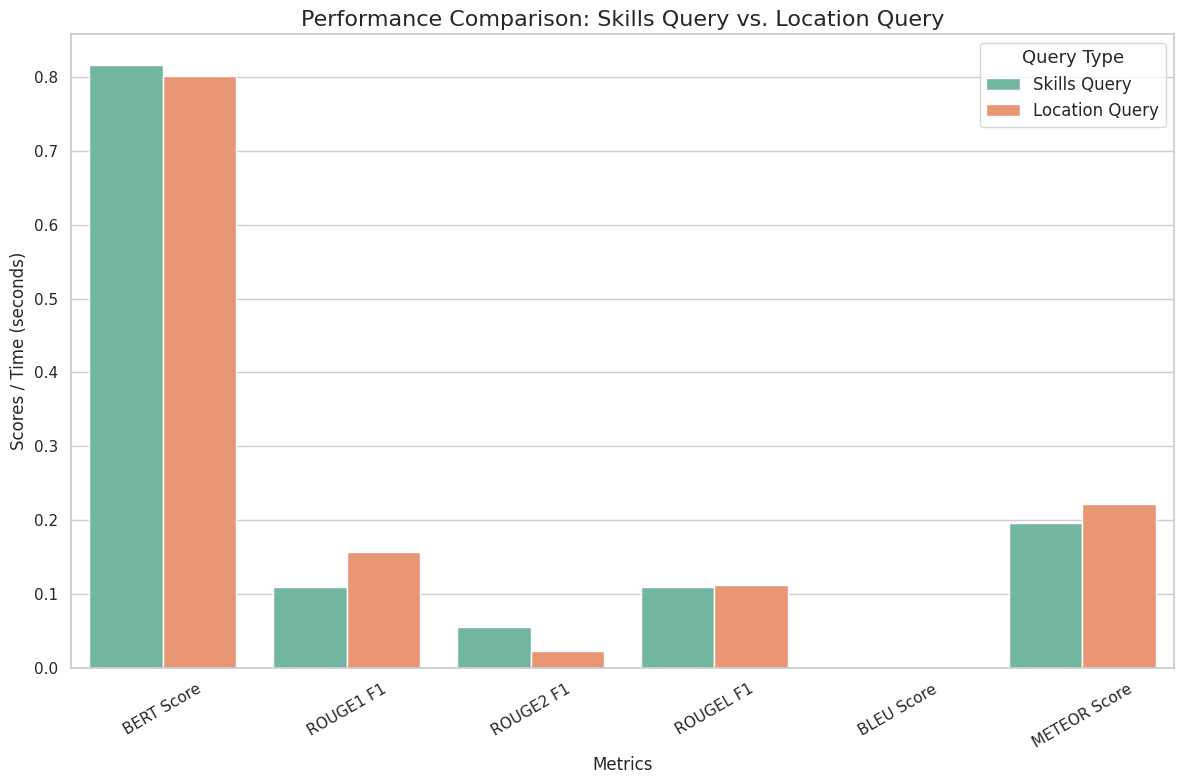

In [ ]:
# Create a dataframe for the data to make plotting easier
metrics_data = {
    'Metric': ['BERT Score', 'ROUGE1 F1', 'ROUGE2 F1', 'ROUGEL F1', 'BLEU Score', 'METEOR Score'],
    'Skills Query': [bert_scores[0], rouge1_f1[0], rouge2_f1[0], rougeL_f1[0], bleu_scores[0], meteor_scores[0]],
    'Location Query': [bert_scores[1], rouge1_f1[1], rouge2_f1[1], rougeL_f1[1], bleu_scores[1], meteor_scores[1]]
}

df = pd.DataFrame(metrics_data)

# Set the style for the plots
sns.set(style="whitegrid")

# Plot comparison of each metric
plt.figure(figsize=(12, 8))
df_melted = df.melt(id_vars="Metric", var_name="Query Type", value_name="Score")

# Create a bar plot for comparison
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Query Type", palette="Set2")

# Customize plot
plt.title('Performance Comparison: Skills Query vs. Location Query', fontsize=16)
plt.ylabel('Scores / Time (seconds)', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=30)
plt.legend(title="Query Type", fontsize=12, title_fontsize='13')

# Save and show plot
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_skills_vs_location_query_comparison.png')
plt.show()


In [ ]:
# Inference on the base model (before fine-tuning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate responses for the job queries
def generate_responses(queries, max_new_tokens=64):
    generated_responses = []

    for query in queries:
        # Prepare the input as expected by the model
        messages = [{"from": "human", "value": query}]

        # Start the timer
        start_time = time.time()

        # Tokenize the input with the template
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
            add_eos_token=True
        )

        # Check the structure of inputs
        if isinstance(inputs, dict):
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
        else:
            input_ids = inputs.to(device)
            attention_mask = None  # If attention mask is not returned, set it to None

        # Generate output
        outputs = model_lora.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,  # Can be None if not provided
            max_new_tokens=max_new_tokens,
            use_cache=True
        )

        # Stop the timer
        end_time = time.time()

        # Calculate the time taken
        time_taken = end_time - start_time

        # Decode the generated output
        decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        generated_responses.append(decoded_output)

    return generated_responses, time_taken

# Example job queries
job_queries = [
    "What roles are available for machine learning engineer?",
    "Which jobs pay over over $150K?",
    "What jobs are available for passionate python developer with 5 years of experience?",
    "What jobs are open in finland?"
]

# Run the inference
generated_descriptions, time_taken = generate_responses(job_queries)

print(f"Time taken to generate the response: {time_taken:.2f} seconds")

# Print generated responses
for i, description in enumerate(generated_descriptions):
    print(f"Query: {job_queries[i]}")
    print(f"Generated Job Description: {description}")
    print("-" * 50)


In [ ]:
# Function to clean and tokenize text
def clean_and_tokenize(text):
    # Lowercase the text and remove special characters
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize by splitting on spaces
    tokens = text.split()
    return set(tokens)

# Function to calculate relevance
def calculate_relevance(query, generated_description):
    # Tokenize the query and generated description
    query_tokens = clean_and_tokenize(query)
    description_tokens = clean_and_tokenize(generated_description)

    # Find the common terms between query and description
    common_terms = query_tokens & description_tokens
    relevance_score = len(common_terms) / len(query_tokens)

    return relevance_score, common_terms

# Example queries and generated descriptions
queries = {
    "Skills": "What roles are available for machine learning engineer?",
    "Salary": "Which jobs pay over over $150K?",
    "Experience": "What jobs are available for passionate python developer with 5 years of experience?",
    "Location": "What jobs are open in finland?"
}

generated_descriptions = {
    "Skills": "What roles are available for machine learning engineer? Machine learning engineers play a crucial role in the development, deployment, and maintenance of machine learning models and systems.",
    "Salary": "Which jobs pay over over $150K? Determining which jobs pay over $150,000 requires considering various factors such as industry, location, experience level, and specific job roles.",
    "Experience": "What jobs are available for passionate python developer with 5 years of experience? As a passionate Python developer with 5 years of experience, you have a strong foundation to explore a variety of job opportunities.",
    "Location": "What jobs are open in finland? As of my knowledge cutoff in early 2023, I cannot provide real-time job listings or current openings in Finland."
}

# Calculate relevance for each query
for query_type, query in queries.items():
    generated_description = generated_descriptions[query_type]
    relevance_score, common_terms = calculate_relevance(query, generated_description)

    print(f"--- {query_type} Query ---")
    print(f"Query: {query}")
    print(f"Generated Description: {generated_description}")
    print(f"Relevance Score: {relevance_score:.2f}")
    print(f"Common Terms: {common_terms}")
    print()



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaMod

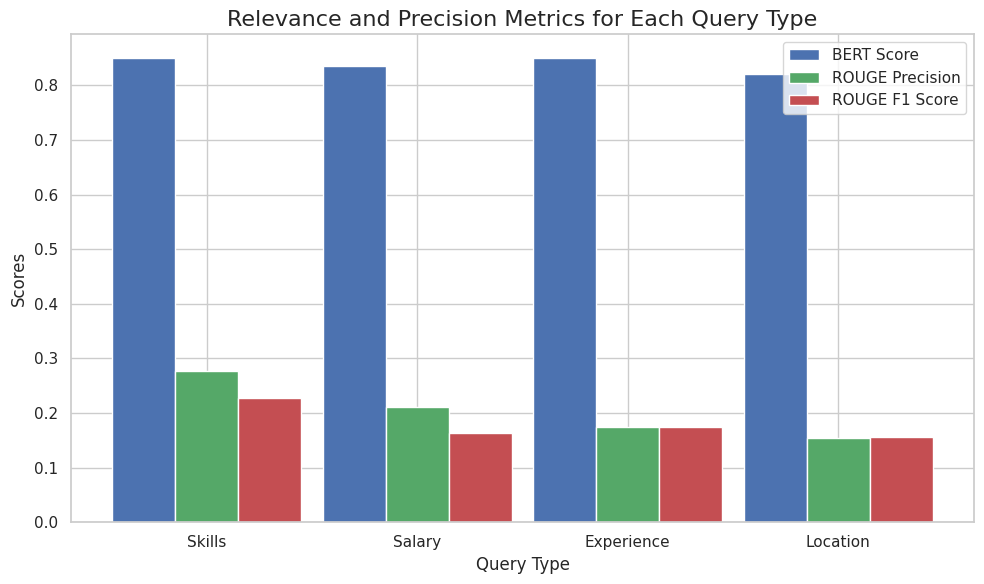

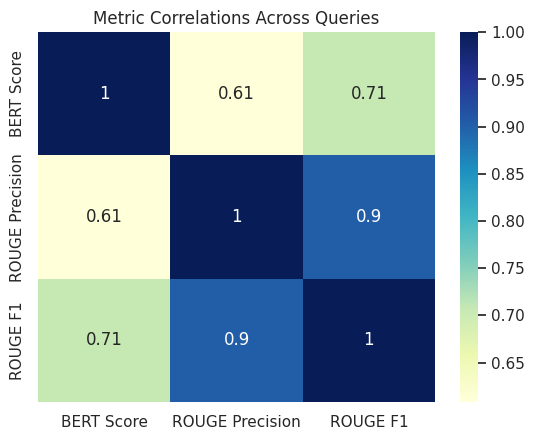

In [ ]:
# Data for Queries, Ground Truths, and Generated Responses
queries = [
    "What roles are available for machine learning engineer?",
    "Which jobs pay over $150K?",
    "What jobs are available for passionate python developer with 5 years of experience?",
    "What jobs are open in Finland?"
]

generated_responses = [
    "What roles are available for machine learning engineer? Machine learning engineers play a crucial role in the development...",
    "Which jobs pay over $150K? Determining which jobs pay over $150,000 requires considering various factors such as industry...",
    "What jobs are available for passionate python developer with 5 years of experience? As a passionate Python developer with 5 years of experience...",
    "What jobs are open in Finland? As of my knowledge cutoff in early 2023, I cannot provide real-time job listings or current openings in Finland..."
]

ground_truths = [
    "Job available in Québec city, Salary: over $150K, Job-Title: senior machine learning engineer Description: vivun is the world s leading provider of presales software...",
    "Job available with a salary of over $150K Location: Calgary, Job-Title: intermediate full stack developer Description: The intermediate full stack developer contributes to all aspects of the sldc process...",
    "Job available in San Francisco, Salary: over $75K, Job-Title: entry level python developer Description: We are looking for entry level software programmers...",
    "Job available in Finland Job-Title: senior frontend developer, Salary: over $150K, Description: Senior frontend location remote Helsinki salary 9000 depends on years of experience..."
]

# Function to calculate BERT Score and ROUGE
def calculate_metrics(generated, reference):
    # BERT Score
    P, R, F1 = score([generated], [reference], lang="en", verbose=False)
    bert_score = F1.item()

    # ROUGE Scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated)

    # Extract Precision for ROUGE-L
    rougeL_precision = rouge_scores['rougeL'].precision
    rougeL_fmeasure = rouge_scores['rougeL'].fmeasure

    return bert_score, rougeL_precision, rougeL_fmeasure

# Store the evaluation results
bert_scores = []
rouge_precisions = []
rouge_f1_scores = []

# Evaluate each query
for generated, reference in zip(generated_responses, ground_truths):
    bert, rouge_prec, rouge_f1 = calculate_metrics(generated, reference)
    bert_scores.append(bert)
    rouge_precisions.append(rouge_prec)
    rouge_f1_scores.append(rouge_f1)

# Visualization of Relevance and Precision

def plot_metrics(query_types, bert_scores, rouge_precisions, rouge_f1_scores):
    ind = np.arange(len(query_types))  # the x locations for the groups
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plots for BERT Scores, ROUGE Precision, ROUGE F1
    ax.bar(ind - width, bert_scores, width, label='BERT Score', color='b')
    ax.bar(ind, rouge_precisions, width, label='ROUGE Precision', color='g')
    ax.bar(ind + width, rouge_f1_scores, width, label='ROUGE F1 Score', color='r')

    # Labels and Titles
    ax.set_xlabel('Query Type', fontsize=12)
    ax.set_ylabel('Scores', fontsize=12)
    ax.set_title('Relevance and Precision Metrics for Each Query Type', fontsize=16)
    ax.set_xticks(ind)
    ax.set_xticklabels(query_types)
    ax.legend()

    # Save and show plot
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/NLX Data/visualizations/{modname}_relevance_precision_comparison.png')
    plt.show()

# Call the plotting function
query_types = ['Skills', 'Salary', 'Experience', 'Location']
plot_metrics(query_types, bert_scores, rouge_precisions, rouge_f1_scores)

# Heatmap Visualization of Correlation between Metrics
def plot_correlation_heatmap(bert_scores, rouge_precisions, rouge_f1_scores):
    data = {
        'BERT Score': bert_scores,
        'ROUGE Precision': rouge_precisions,
        'ROUGE F1': rouge_f1_scores
    }

    df = np.corrcoef([bert_scores, rouge_precisions, rouge_f1_scores])

    sns.heatmap(df, annot=True, cmap="YlGnBu", xticklabels=data.keys(), yticklabels=data.keys())
    plt.title("Metric Correlations Across Queries")
    plt.savefig(f"/content/drive/MyDrive/NLX Data/visualizations/{modname}_query_correlations_heatmap.png")
    plt.show()

# Call the heatmap function
plot_correlation_heatmap(bert_scores, rouge_precisions, rouge_f1_scores)
